In [3]:
import file_locations
import innvestigate
import matplotlib.pyplot as plt
import numpy as np
from keras.applications import vgg16
from keras.models import load_model
from keras.preprocessing import image as image_utils
from keras import Model

In [4]:
model = load_model(file_locations.PATH_TO_CHECKPOINTS+'weights.2019.11.15-1130-streamline.hdf5')

In [5]:
#remove softmax
out = model.layers[-2].output
model_nsm = Model(model.inputs, out)

## Relevance Analysis

In [12]:
# define model analyser
analyzer = innvestigate.create_analyzer("lrp.sequential_preset_b_flat", model_nsm)

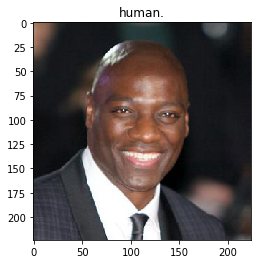

In [13]:
# grab image from database
image = image_utils.load_img(file_locations.PATH_TO_IMDB_GENDER+'0/2452600_1967-08-22_2013.jpg', target_size=(224,224))
plt.imshow(image)
plt.title("human.")
x = image_utils.img_to_array(image)
x = np.expand_dims(x,0)
x = vgg16.preprocess_input(x)

In [14]:
a = analyzer.analyze(x)

In [15]:
from matplotlib.colors import LinearSegmentedColormap
blueblackred_colors = np.array(
  [
      [0.8, 1, 1],  # cyan-white
      [0, 1, 1],  # cyan
      [0, 0, 1],  # blue
      [0, 0, 0],  # black
      [1, 0, 0],  # red
      [1, 1, 0],  # yellow
      [1, 1, 0.8],  # yellow-white
  ]
)
blueblackred = LinearSegmentedColormap.from_list("blueblackred", blueblackred_colors)

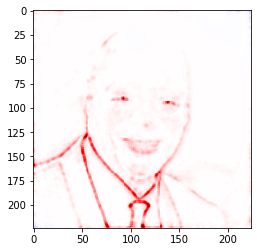

In [16]:
r = a[0].sum(axis=2)
r /= np.max(np.abs(r))
plt.imshow(r, cmap='seismic', clim=[-1,1]);

1.0

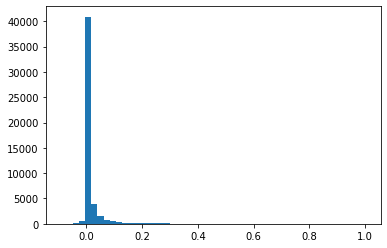

In [17]:
plt.hist(r.ravel(),bins=50);
np.max(r)

## Batch Processing

In [18]:
#grab some files
import random, os, time
filenames = random.sample(os.listdir(file_locations.PATH_TO_IMDB_GENDER+'0/'), 20)
filenames = [file_locations.PATH_TO_IMDB_GENDER+'0/'+s for s in filenames]

In [19]:
filenames

['/biac2/kgs/projects/deepRFs/IMDB_Gender/0/1598538_1943-01-17_1967.jpg',
 '/biac2/kgs/projects/deepRFs/IMDB_Gender/0/173445_1893-02-19_1942.jpg',
 '/biac2/kgs/projects/deepRFs/IMDB_Gender/0/11466859_1949-10-01_1940.jpg',
 '/biac2/kgs/projects/deepRFs/IMDB_Gender/0/40396407_1923-02-16_2013.jpg',
 '/biac2/kgs/projects/deepRFs/IMDB_Gender/0/4667545_1940-09-23_2008.jpg',
 '/biac2/kgs/projects/deepRFs/IMDB_Gender/0/35647209_1988-11-15_2013.jpg',
 '/biac2/kgs/projects/deepRFs/IMDB_Gender/0/45007282_1995-01-04_2015.jpg',
 '/biac2/kgs/projects/deepRFs/IMDB_Gender/0/46591147_1992-09-13_2014.jpg',
 '/biac2/kgs/projects/deepRFs/IMDB_Gender/0/977763_1958-08-15_2011.jpg',
 '/biac2/kgs/projects/deepRFs/IMDB_Gender/0/449982_1975-05-15_2008.jpg',
 '/biac2/kgs/projects/deepRFs/IMDB_Gender/0/3218656_1957-07-30_2006.jpg',
 '/biac2/kgs/projects/deepRFs/IMDB_Gender/0/850575_1957-10-27_2013.jpg',
 '/biac2/kgs/projects/deepRFs/IMDB_Gender/0/12251833_1608-04-23_1984.jpg',
 '/biac2/kgs/projects/deepRFs/IMDB_G

In [20]:
def relevanceMap(f,hush=False,mask=np.ones((224,224,3))):
    pics = []
    batch = np.ones((len(f),224,224,3))
    for i in range(len(f)):
        image = image_utils.load_img(f[i], target_size=(224,224))
        x = image_utils.img_to_array(image)*mask
        batch[i,:,:,:] = x
        pics.append(image)
        
    batch = vgg16.preprocess_input(batch)
    a = analyzer.analyze(batch)
    r = a.sum(axis=3)
    r /= np.expand_dims(np.expand_dims(np.max(np.abs(r), axis=(1,2)),axis=-1),axis=-1)
   
    return (r, pics)

In [21]:
(rs,ps) = relevanceMap(filenames)

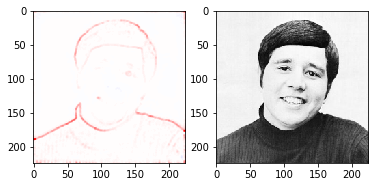

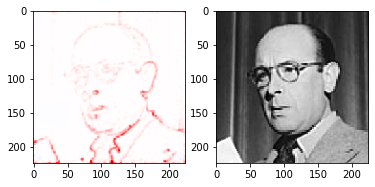

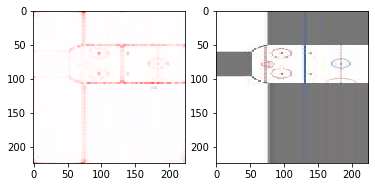

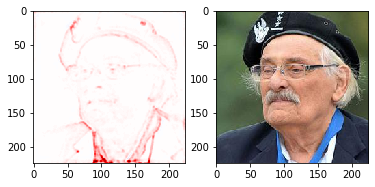

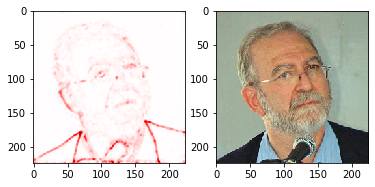

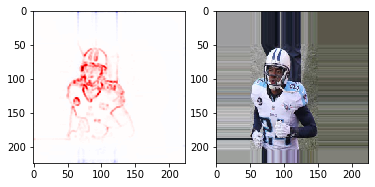

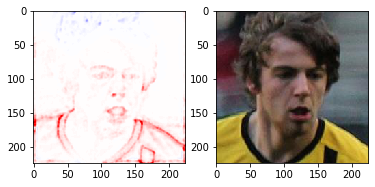

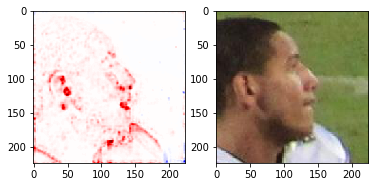

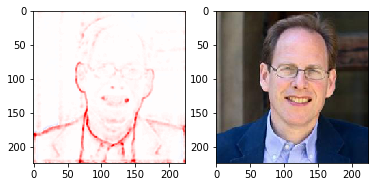

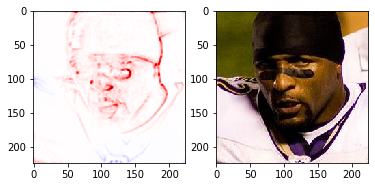

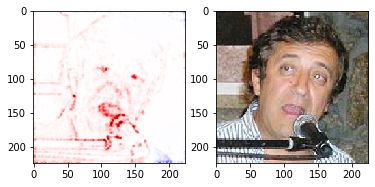

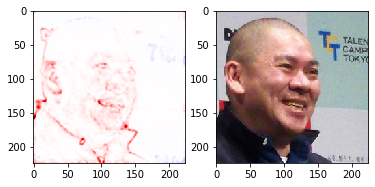

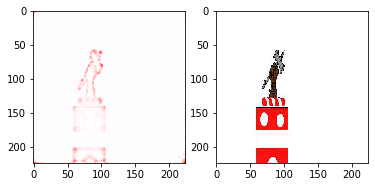

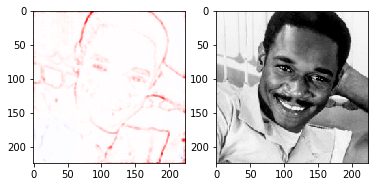

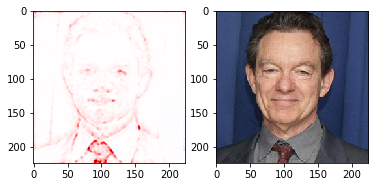

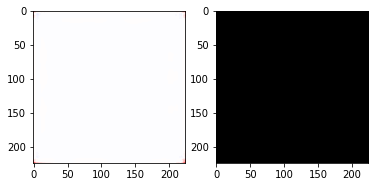

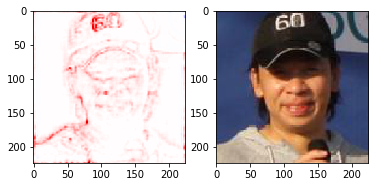

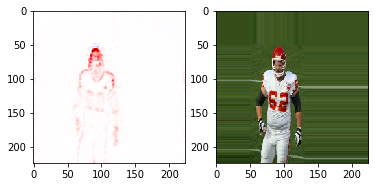

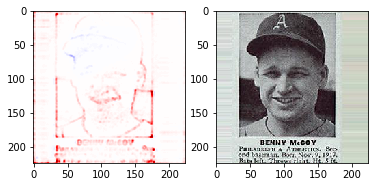

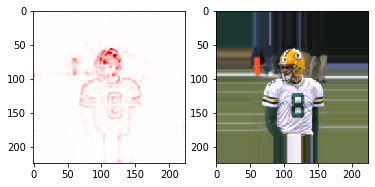

In [22]:
for i in range(len(rs)):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(rs[i], cmap="seismic", clim=[-1,1])
    #plt.colorbar()
    plt.subplot(1,2,2)
    plt.imshow(ps[i])

## This, but on KGS Faces

In [16]:
front_view_filenames = []
front_view_classes = []
for base, dirs, files in os.walk(file_locations.PATH_TO_IMDB_GENDER+'../../FaceDataCp/'): 
    for filename in files:
        if "000." in filename or "_0." in filename:
            front_view_filenames.append(base+"/"+filename)

In [ ]:
len(front_view_filenames)

In [ ]:
batch = np.zeros((101,224,224,3))
plt.figure(figsize=(20,10))
for i in range(len(front_view_filenames)):
    filename = front_view_filenames[i]
    image = image_utils.load_img(filename,target_size=(224, 224))
    x = image_utils.img_to_array(image)
    batch[i] = x
    plt.subplot(11,10,i+1)
    plt.imshow(batch[i]/255)
    plt.title(i)
    
batch = vgg16.preprocess_input(batch)

In [ ]:
(rs_kgs,ps_kgs) = relevanceMap(front_view_filenames[:5]) #test on small piece first

In [ ]:
for i in range(len(rs_kgs)):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(rs_kgs[i], cmap="seismic", clim=[-1,1])
    #plt.colorbar()
    plt.subplot(1,2,2)
    plt.imshow(ps_kgs[i])

In [ ]:
plt.figure()

plt.subplot(1,2,1)
plt.imshow(np.average(rs_kgs, axis=0), cmap="seismic", clim=[-1,1])

plt.subplot(1,2,2)
plt.imshow(np.average(np.array(list(map(image_utils.img_to_array,ps_kgs)))/255, axis=0))

In [ ]:
plt.hist(np.average(rs_kgs, axis=0).ravel());

## Diffs

In [ ]:
m_rs = []
f_rs = []
m_ps = []
f_ps = []
for i in range(len(front_view_filenames[:5])): #test on small piece first
    if (( front_view_filenames[i].split('/')[6].split('_')[1]) == 'f') :
        f_rs.append(rs_kgs[i])
        f_ps.append(ps_kgs[i])
    else:
        m_rs.append(rs_kgs[i])
        m_ps.append(ps_kgs[i])
    

In [ ]:
fig, axes = plt.subplots(figsize=(24, 16), nrows=2, ncols=3)

# average male
axes[0, 0].imshow(np.average(m_rs, axis=0), cmap="seismic", clim=[-1,1])
axes[1, 0].imshow(np.average(np.array(list(map(image_utils.img_to_array,m_ps)))/255, axis=0))

# average female
axes[0, 1].imshow(np.average(f_rs, axis=0), cmap="seismic", clim=[-1,1])
axes[1, 1].imshow(np.average(np.array(list(map(image_utils.img_to_array,f_ps)))/255, axis=0))

# difference
axes[0, 2].imshow(np.average(f_rs, axis=0)-np.average(m_rs, axis=0), cmap="seismic", clim=[-1,1])
axes[1, 2].imshow(np.average(np.array(list(map(image_utils.img_to_array,m_ps)))/255, axis=0))

## Iterative Analysis

In [17]:
numframes = 30
numimages = 101
frames = []
m = np.ones((224,224,3))

for i in range(20):
    print("Calculating frame",i+1,"of",numframes,"...")
    
    #calc relevance on images
    (rs_kgs,ps_kgs) = relevanceMap(front_view_filenames[:numimages],hush=True, mask=m)
    
    #plot this frame's relevance, avg image used, and the mask
    #plt.figure(figsize=(5, 5))
    #plt.subplot(1,3,1)
    #plt.imshow(np.average(rs_kgs, axis=0), cmap="seismic", clim=[-1,1])
    #plt.subplot(1,3,2)
    #plt.imshow(np.average(np.array(list(map(image_utils.img_to_array,ps_kgs)))/255, axis=0))
    #plt.subplot(1,3,3)
    #plt.imshow(m, cmap="seismic", clim=[0,1])
    
    #update frames
    frames.append((rs_kgs,ps_kgs,np.copy(m)))
    
    #find top 1% of pixels
    hinge = np.sort(np.average(rs_kgs, axis=0).ravel())[-int(224*224*0.1)];

    #update mask
    m[np.average(rs_kgs, axis=0) >= hinge] = 0
    
    #save to file so i dont have to run this over and over again
    np.savez("./iterative_relevances_lrp/frame"+str(i)+".npz", frames[i])
    
    

Calculating frame 1 of 30 ...
Calculating frame 2 of 30 ...
Calculating frame 3 of 30 ...
Calculating frame 4 of 30 ...
Calculating frame 5 of 30 ...
Calculating frame 6 of 30 ...
Calculating frame 7 of 30 ...
Calculating frame 8 of 30 ...
Calculating frame 9 of 30 ...
Calculating frame 10 of 30 ...
Calculating frame 11 of 30 ...
Calculating frame 12 of 30 ...
Calculating frame 13 of 30 ...
Calculating frame 14 of 30 ...
Calculating frame 15 of 30 ...
Calculating frame 16 of 30 ...
Calculating frame 17 of 30 ...
Calculating frame 18 of 30 ...
Calculating frame 19 of 30 ...
Calculating frame 20 of 30 ...


In [63]:
#load frames from file
lframes = []
for i in range(20):
    lframes.append(list(np.load("./iterative_relevances_lrp/frame"+str(i)+".npz", allow_pickle=True).values())[0])

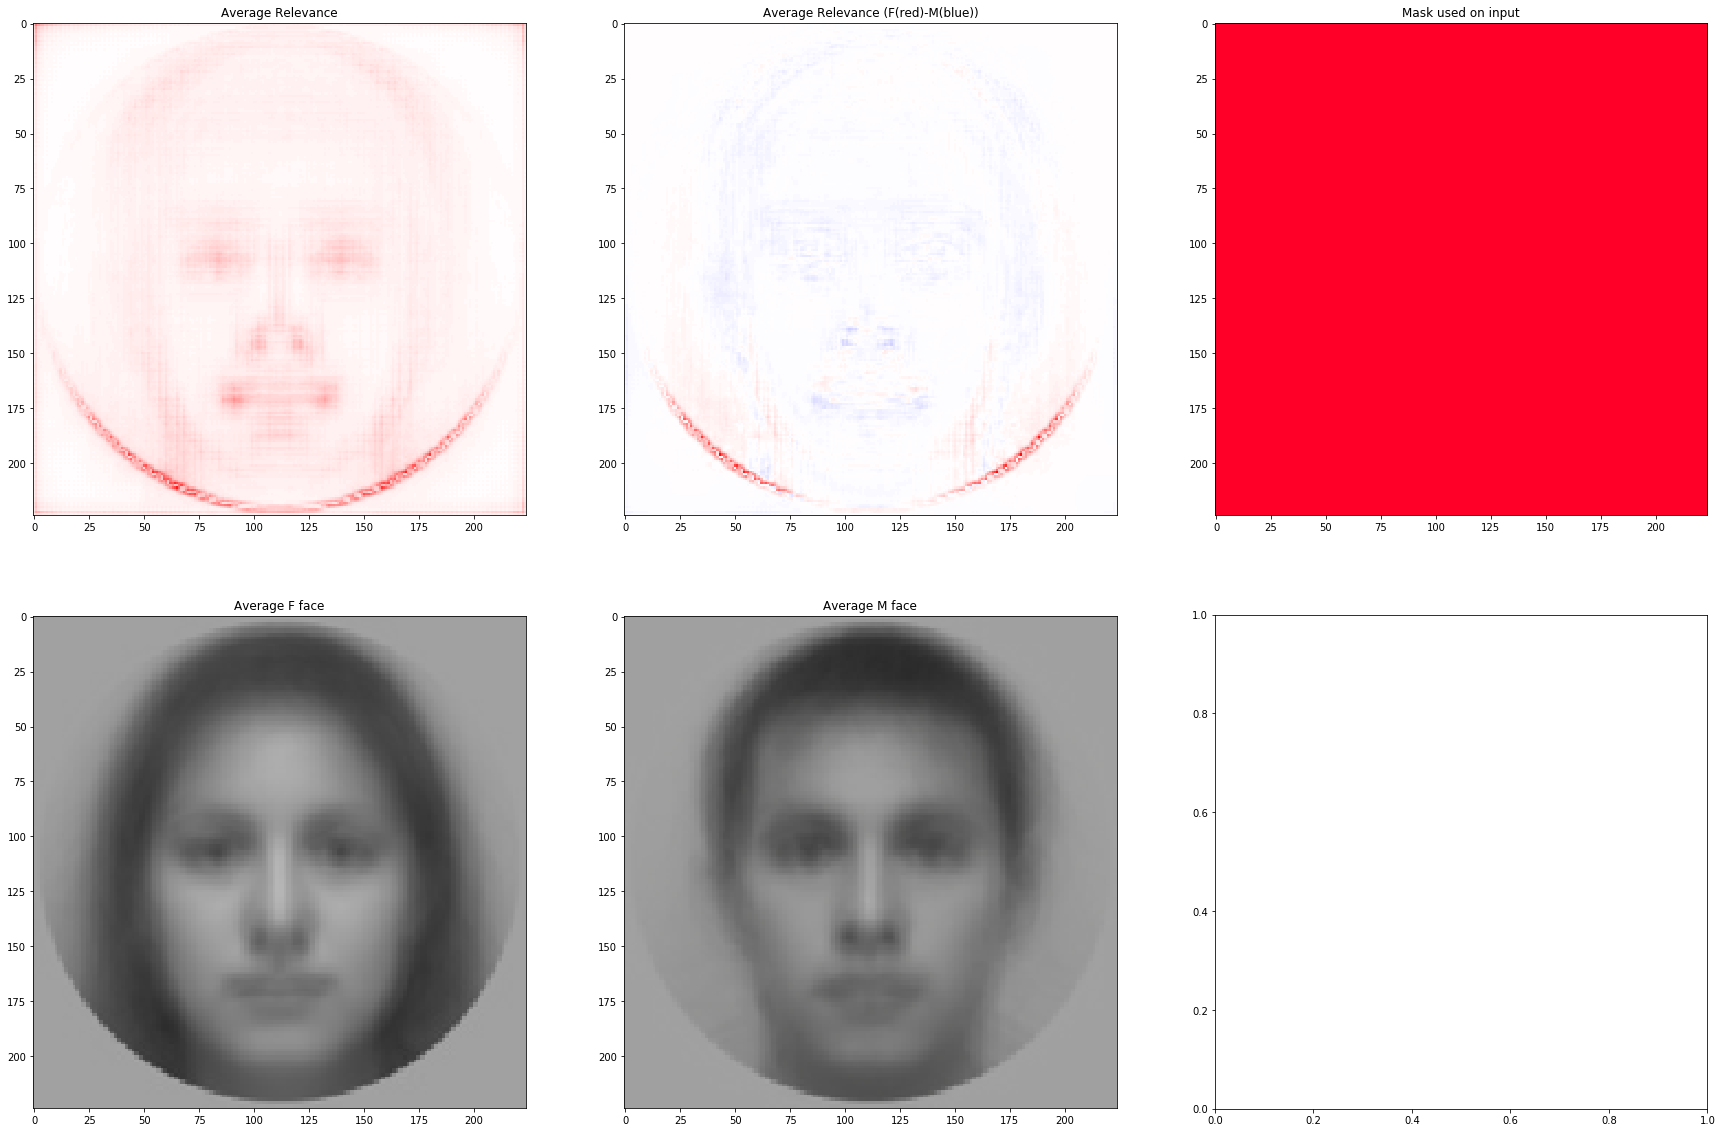

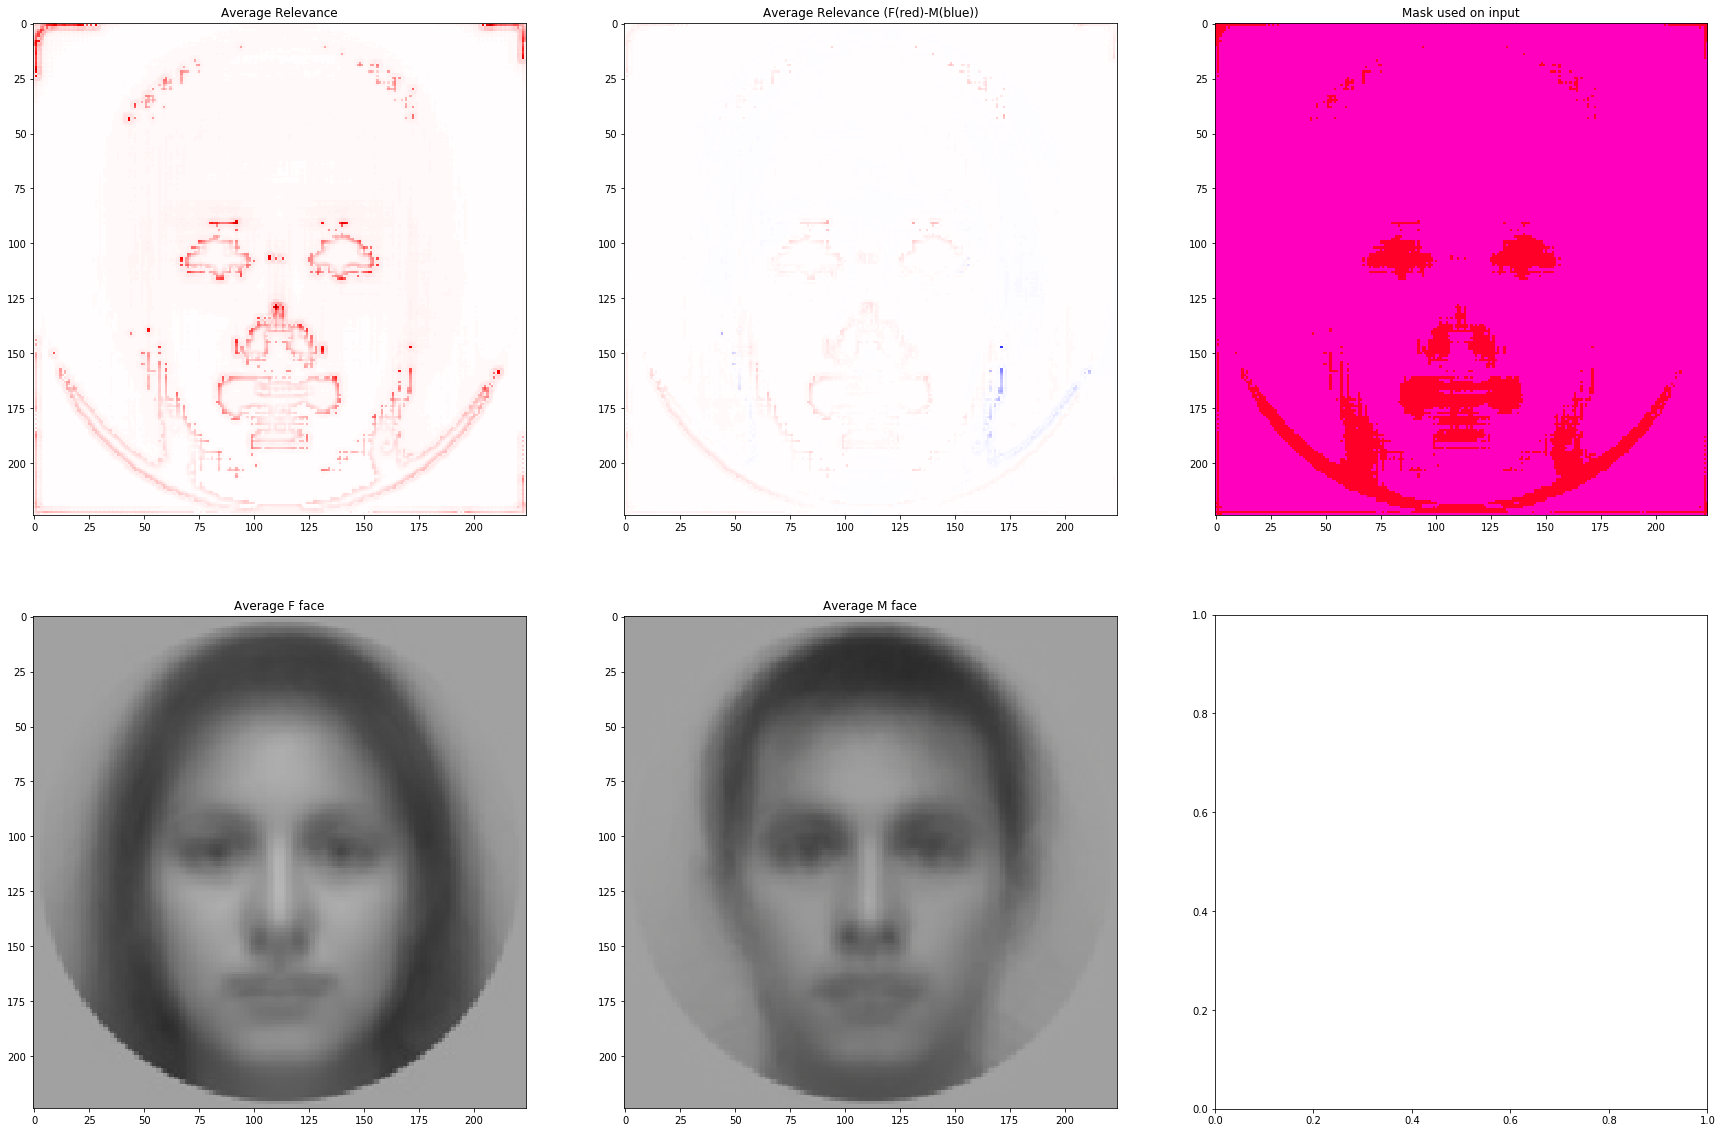

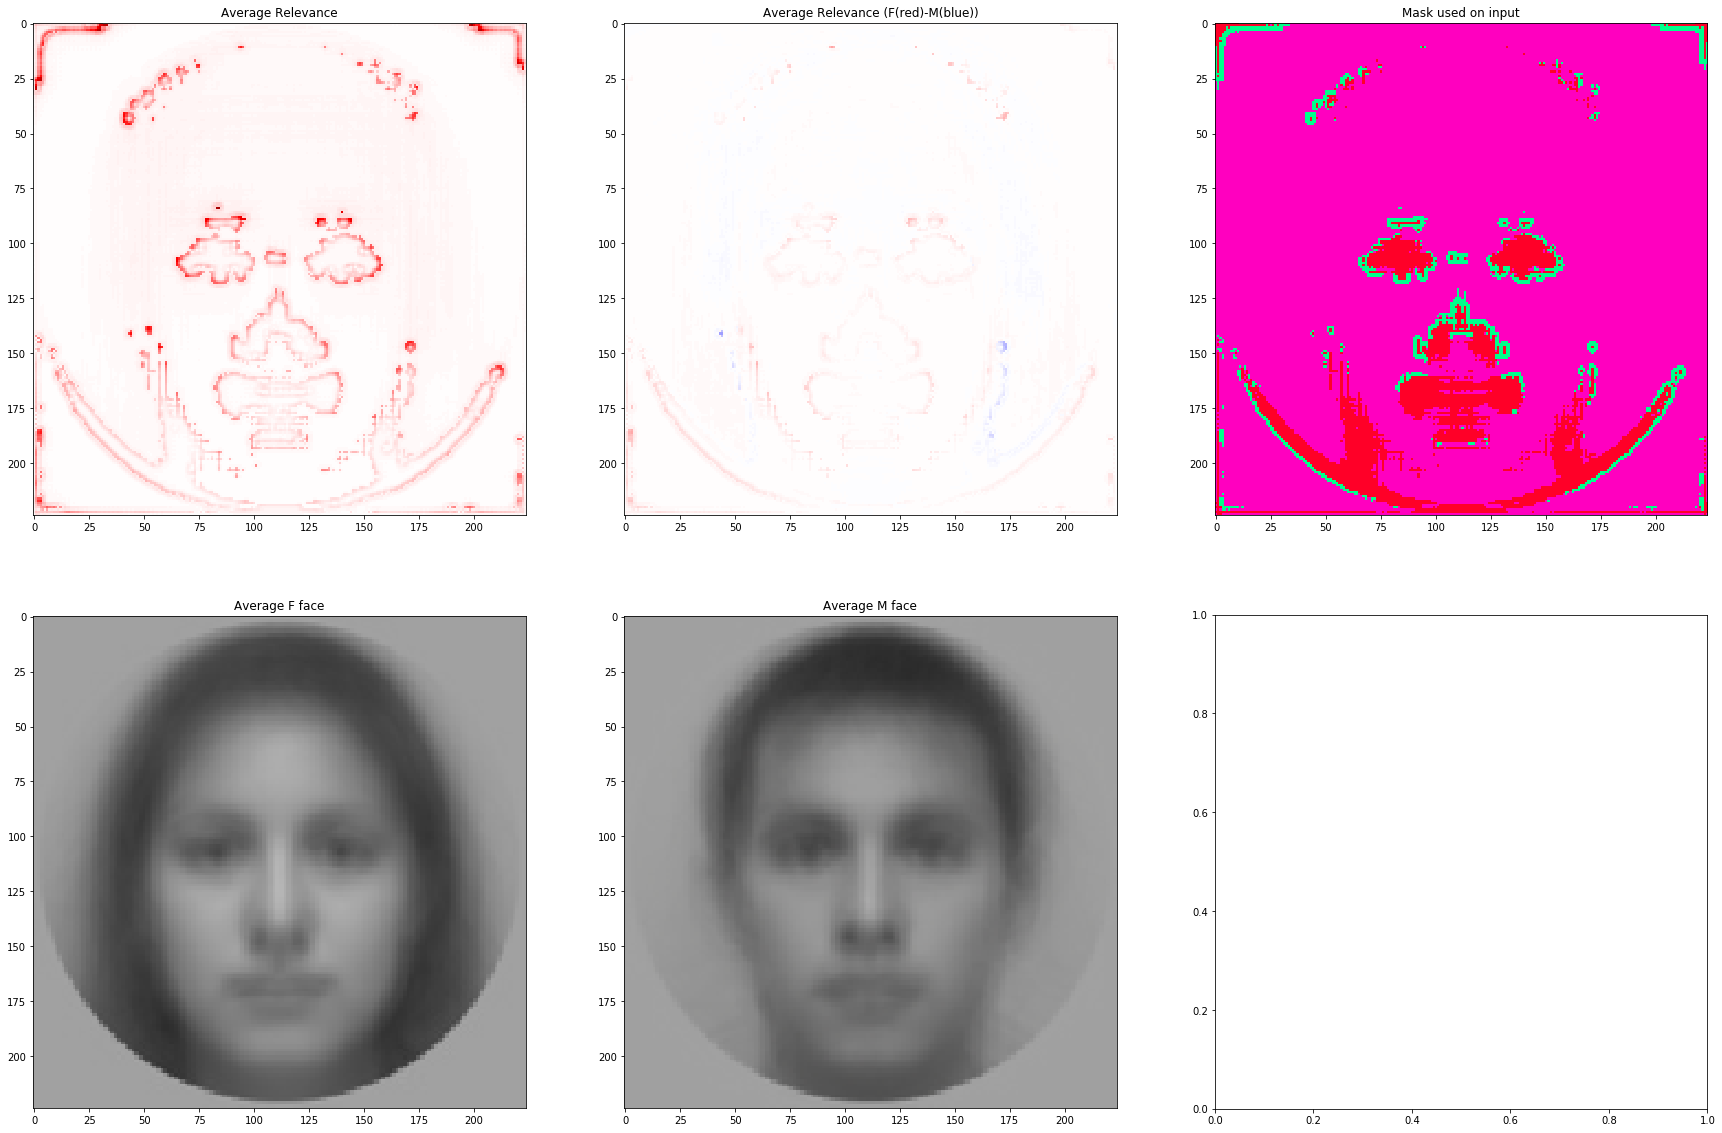

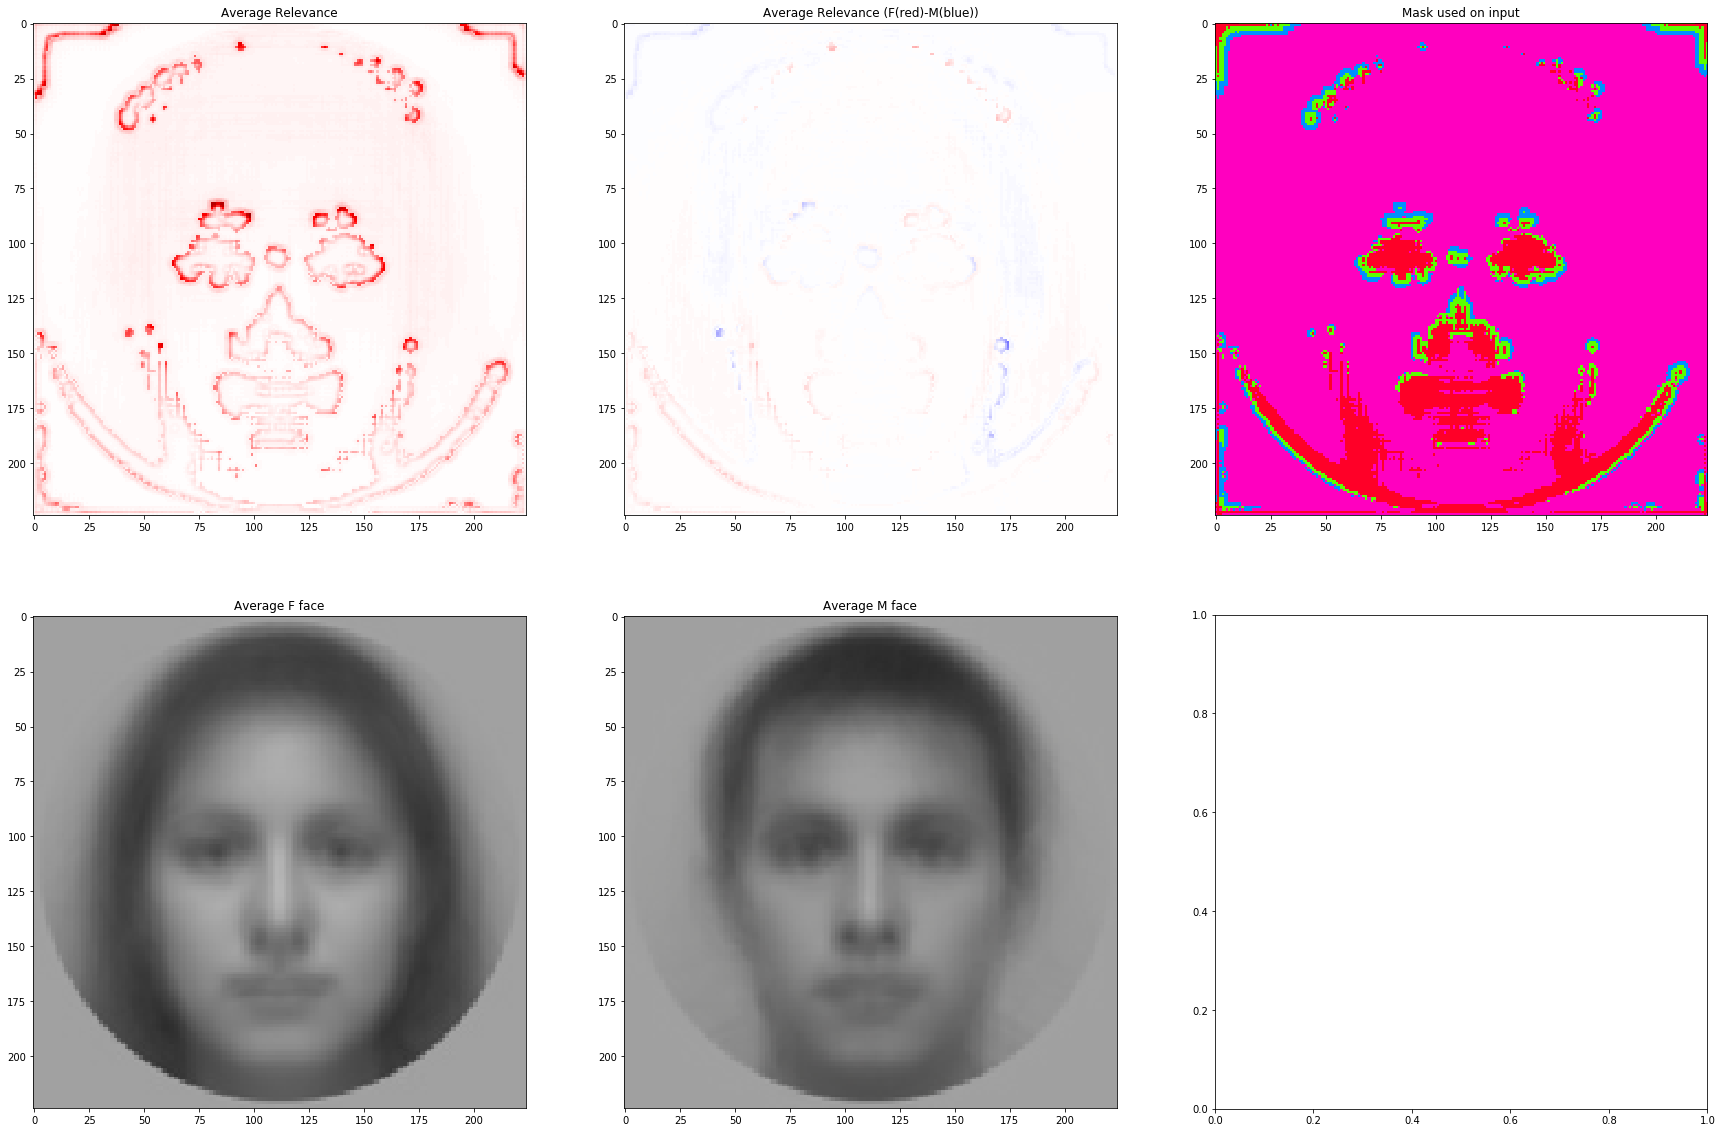

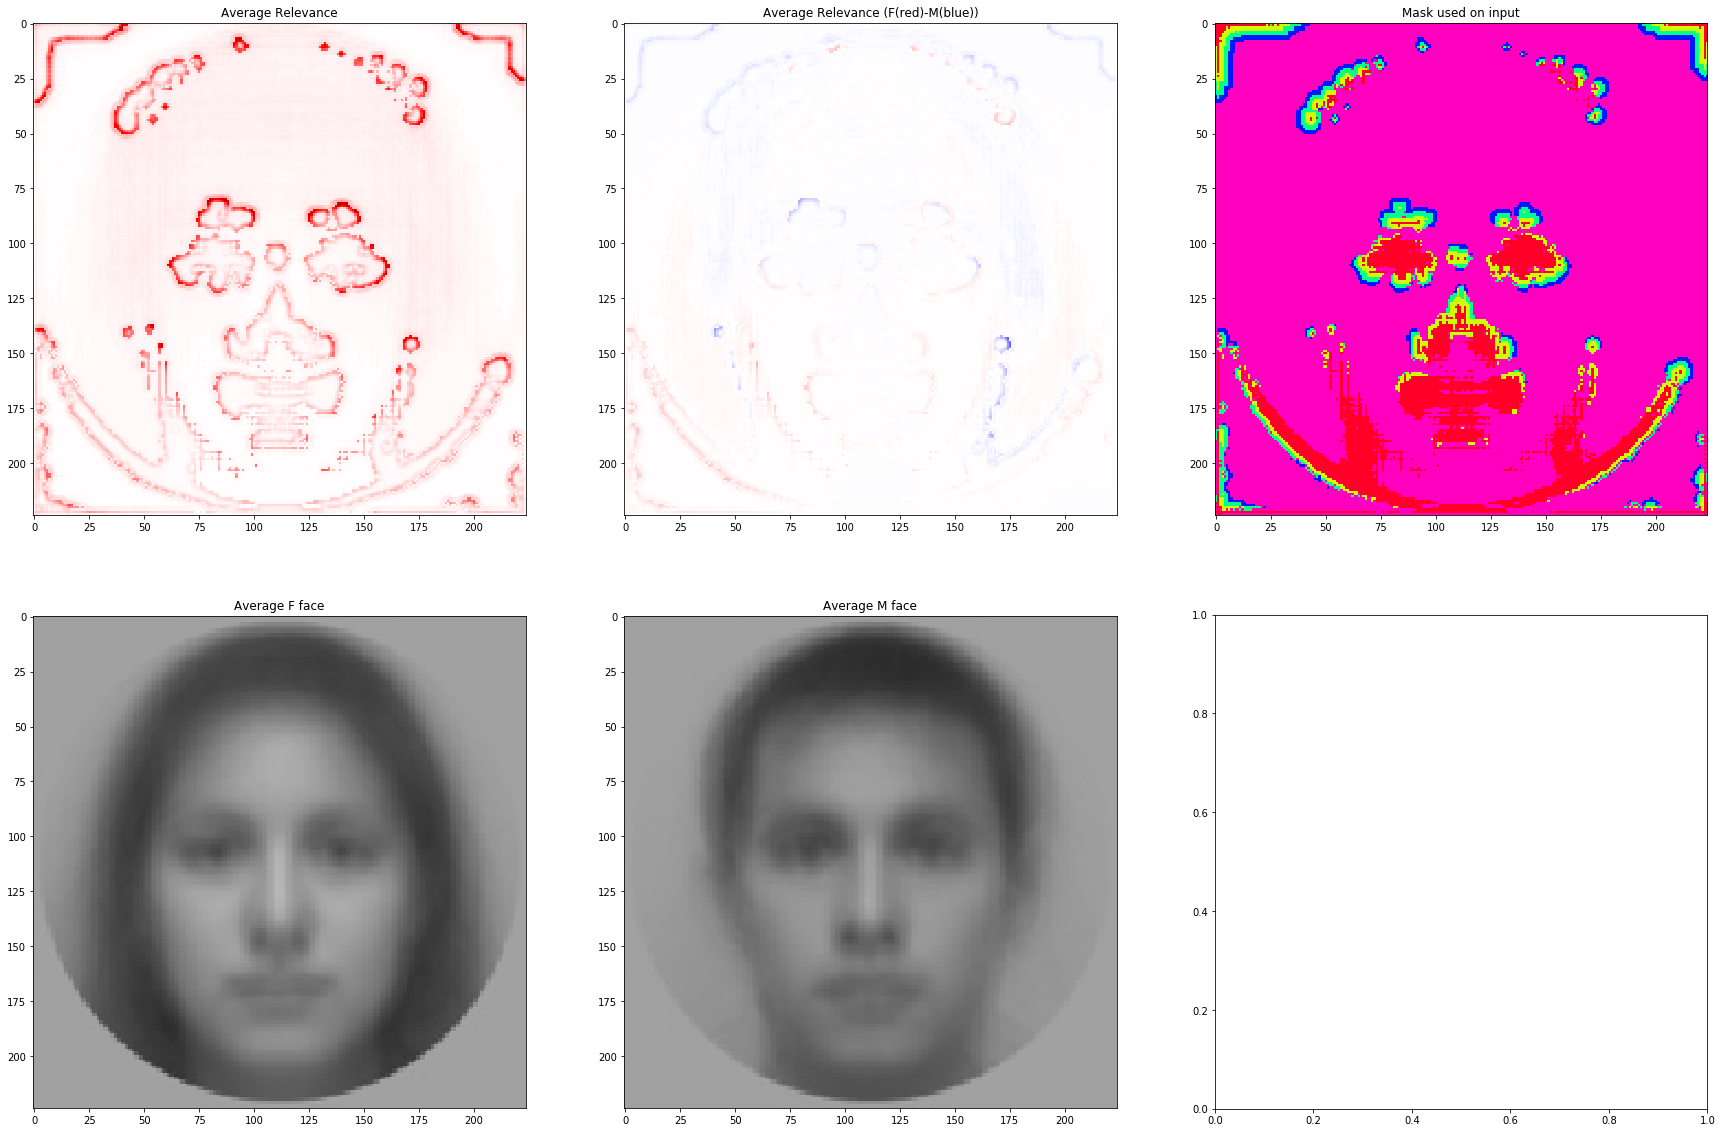

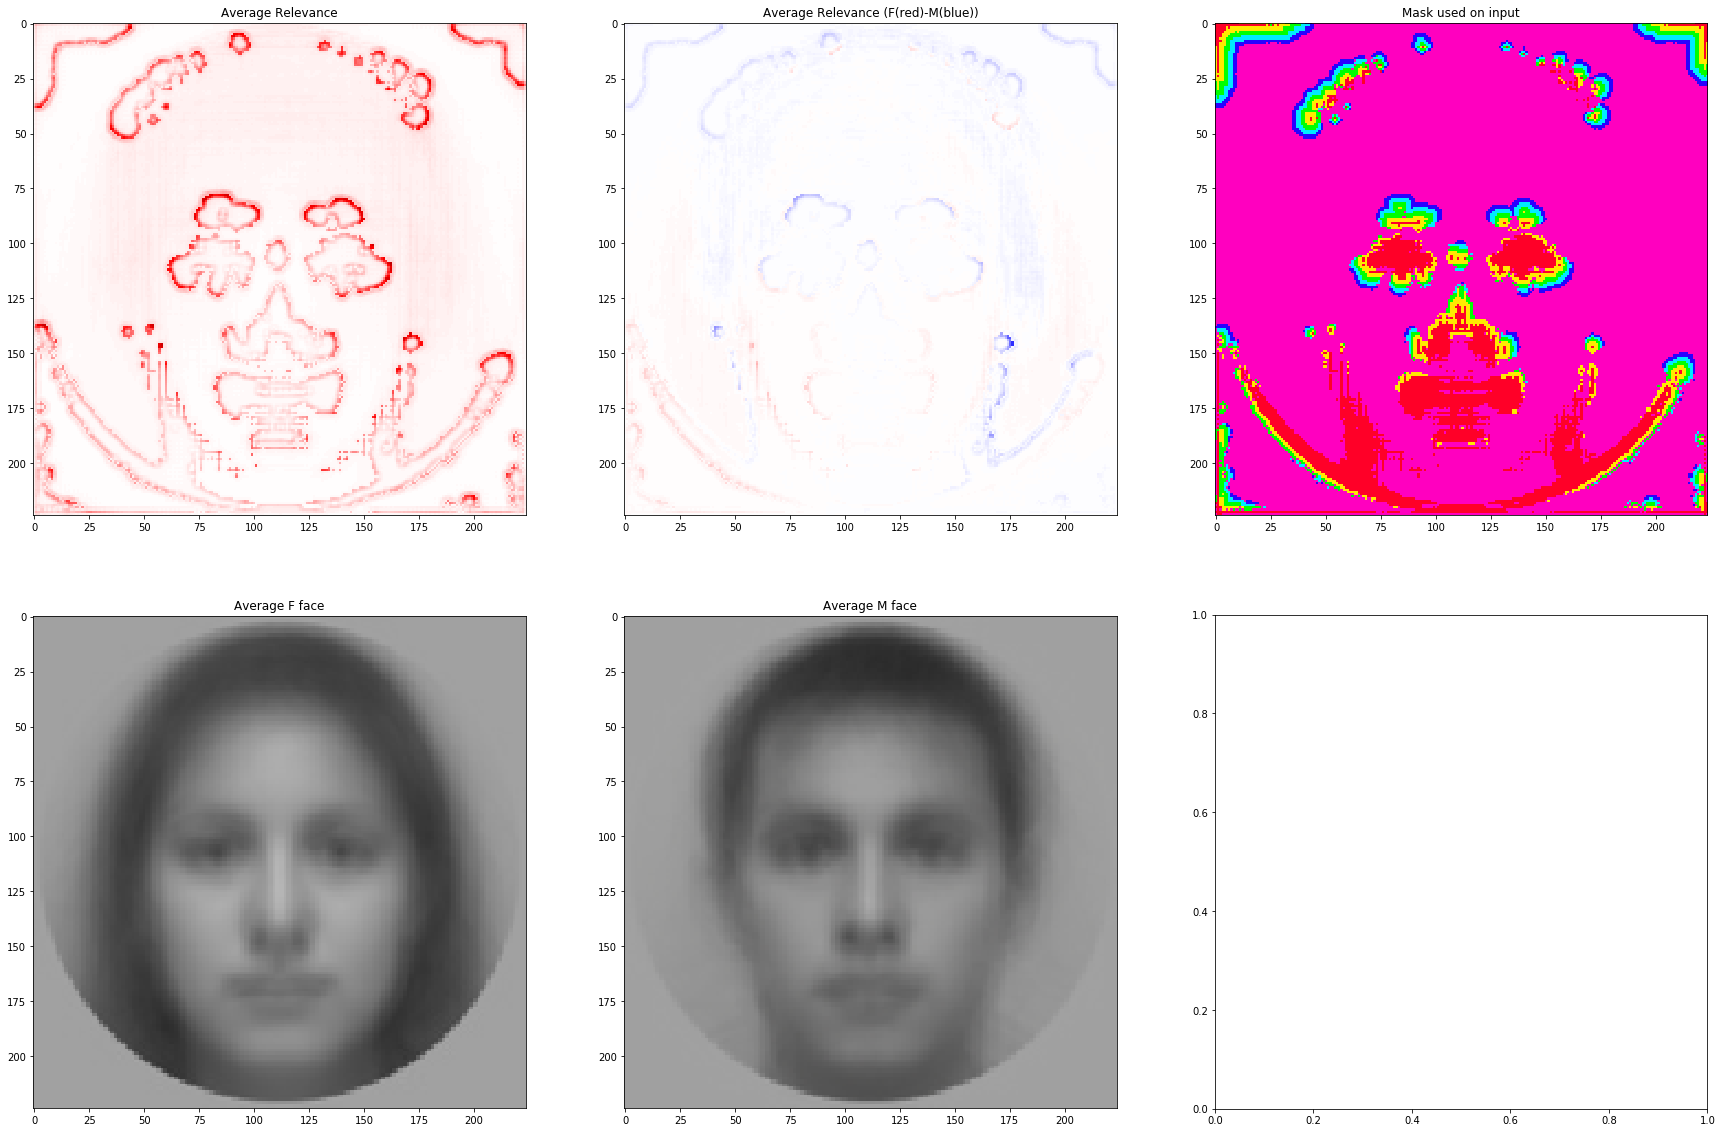

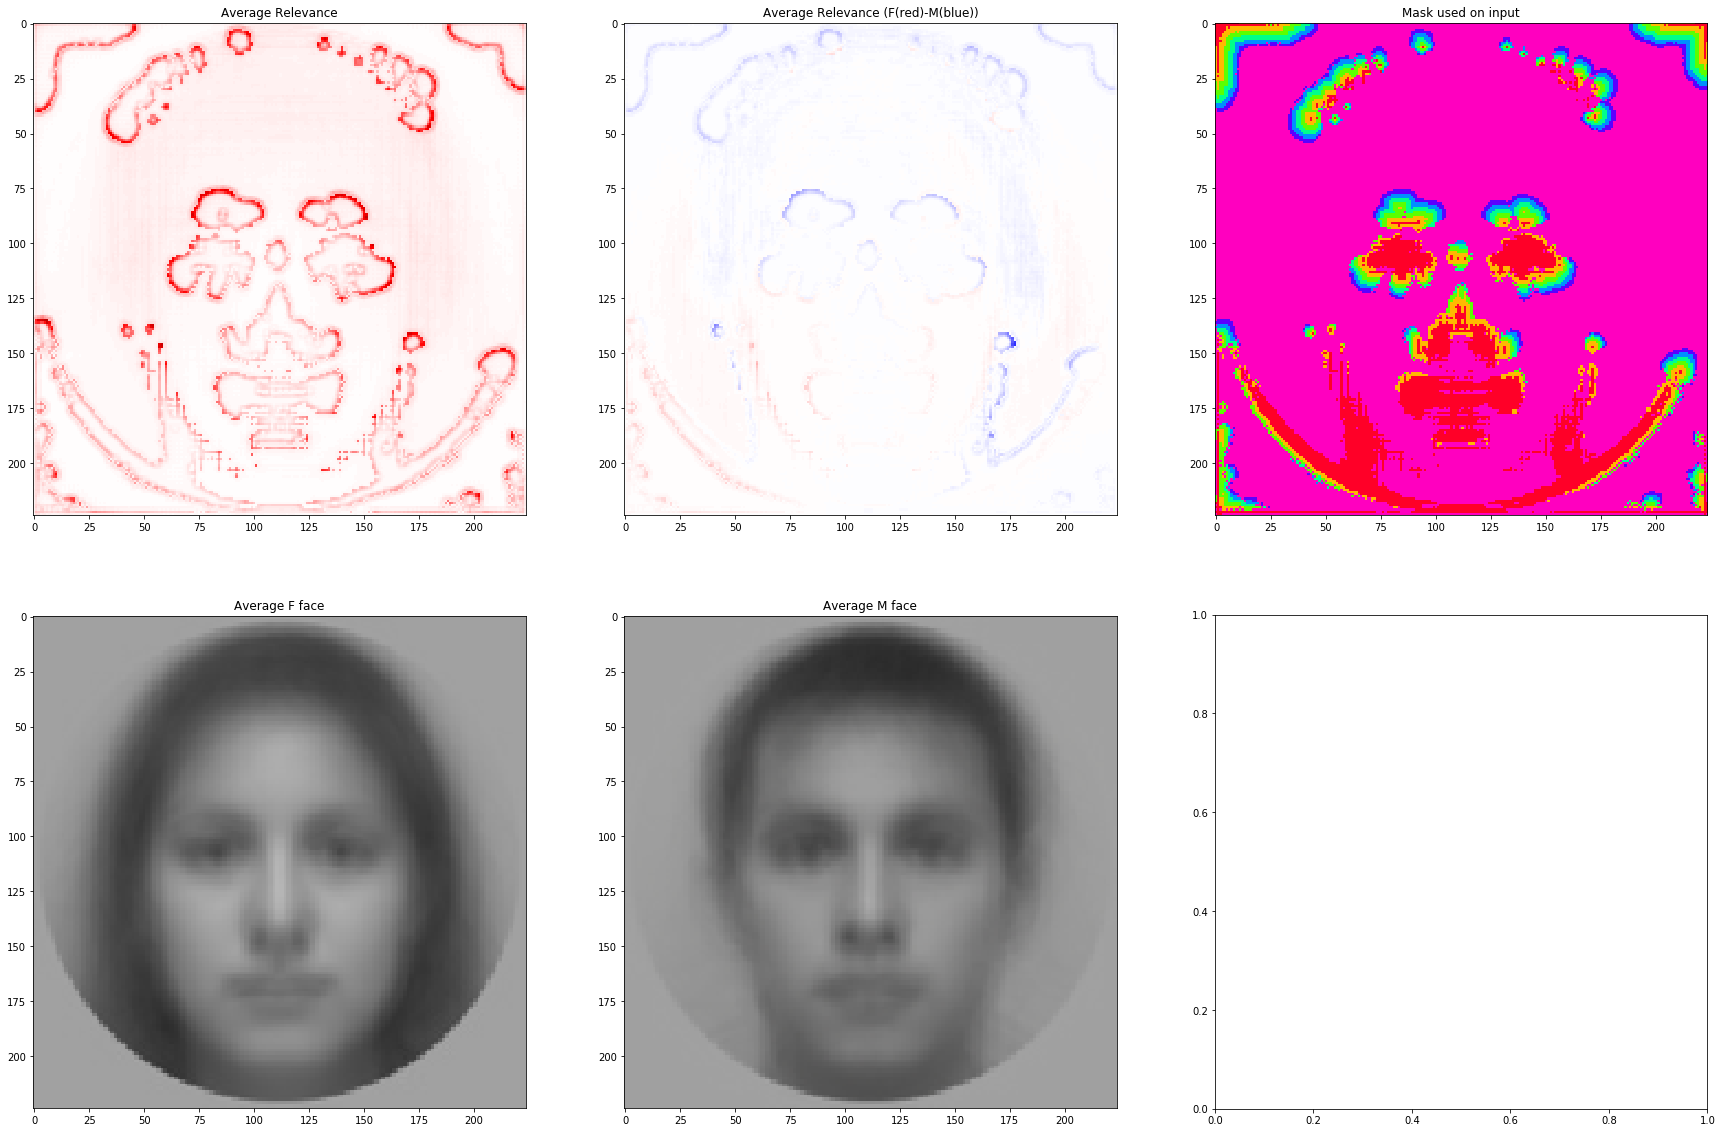

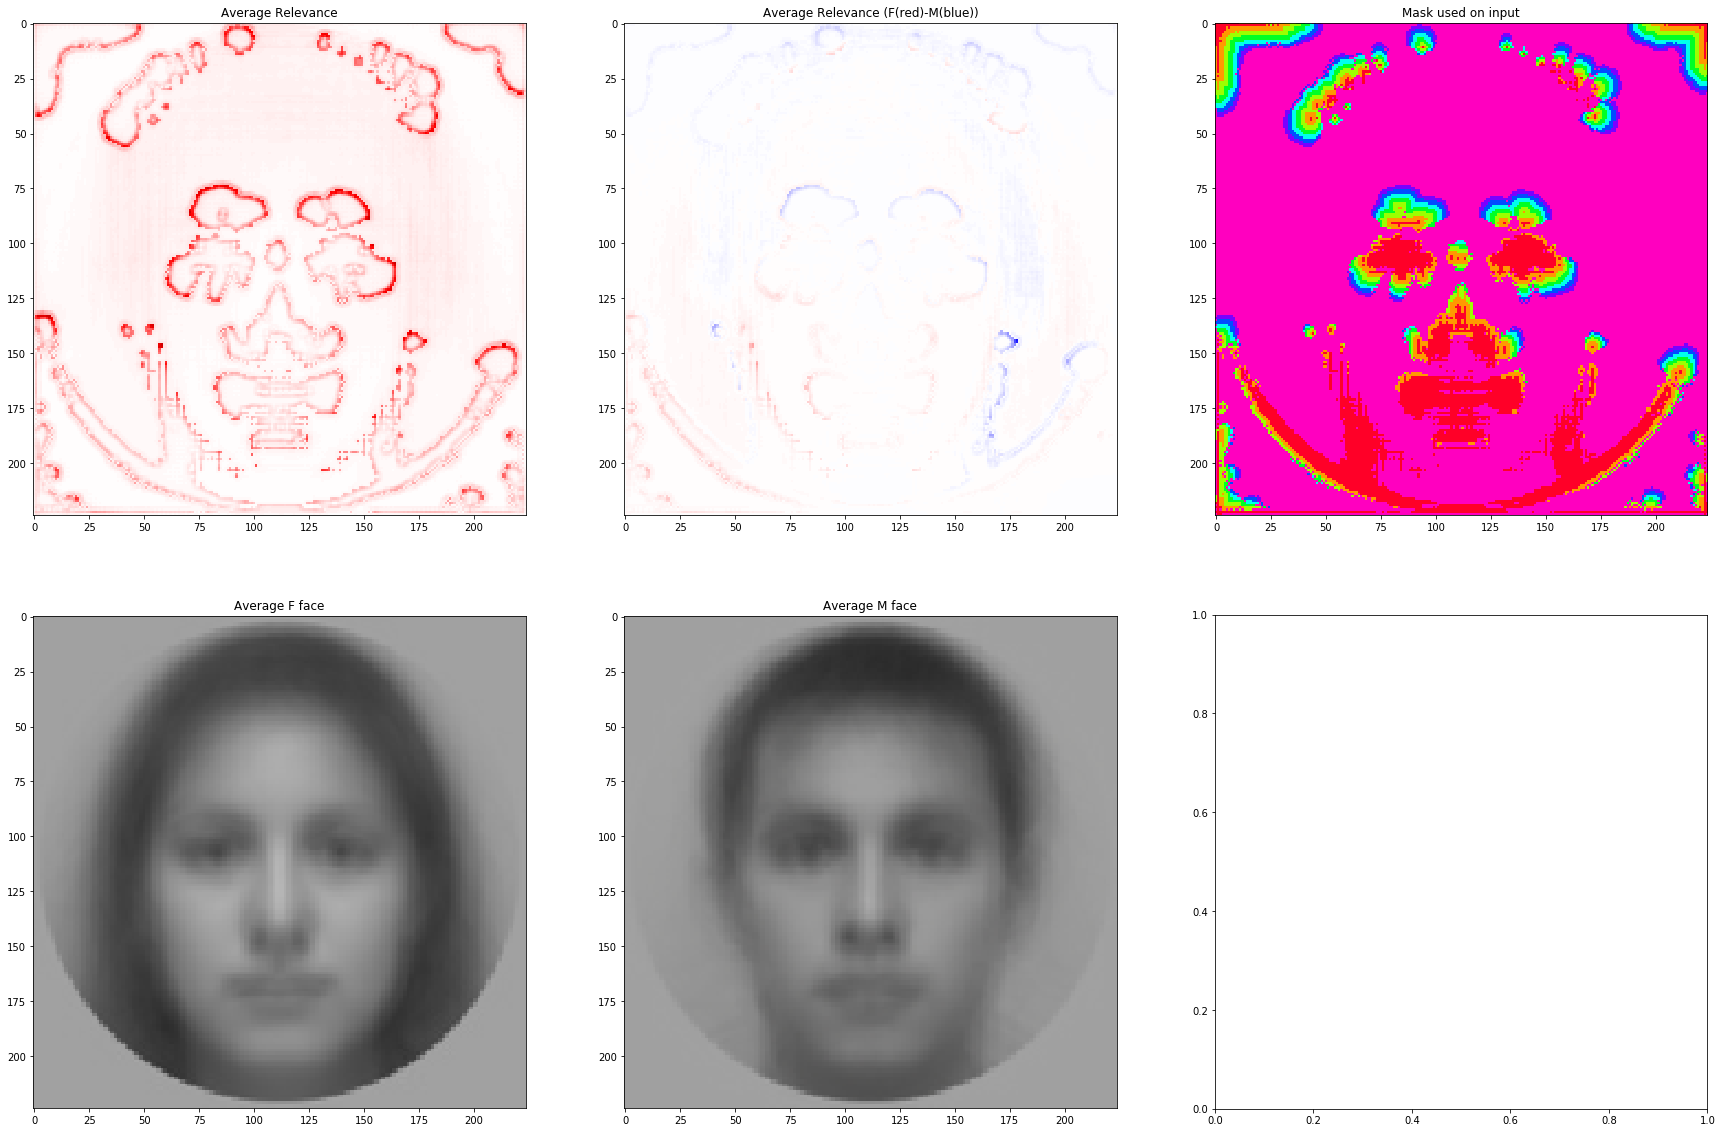

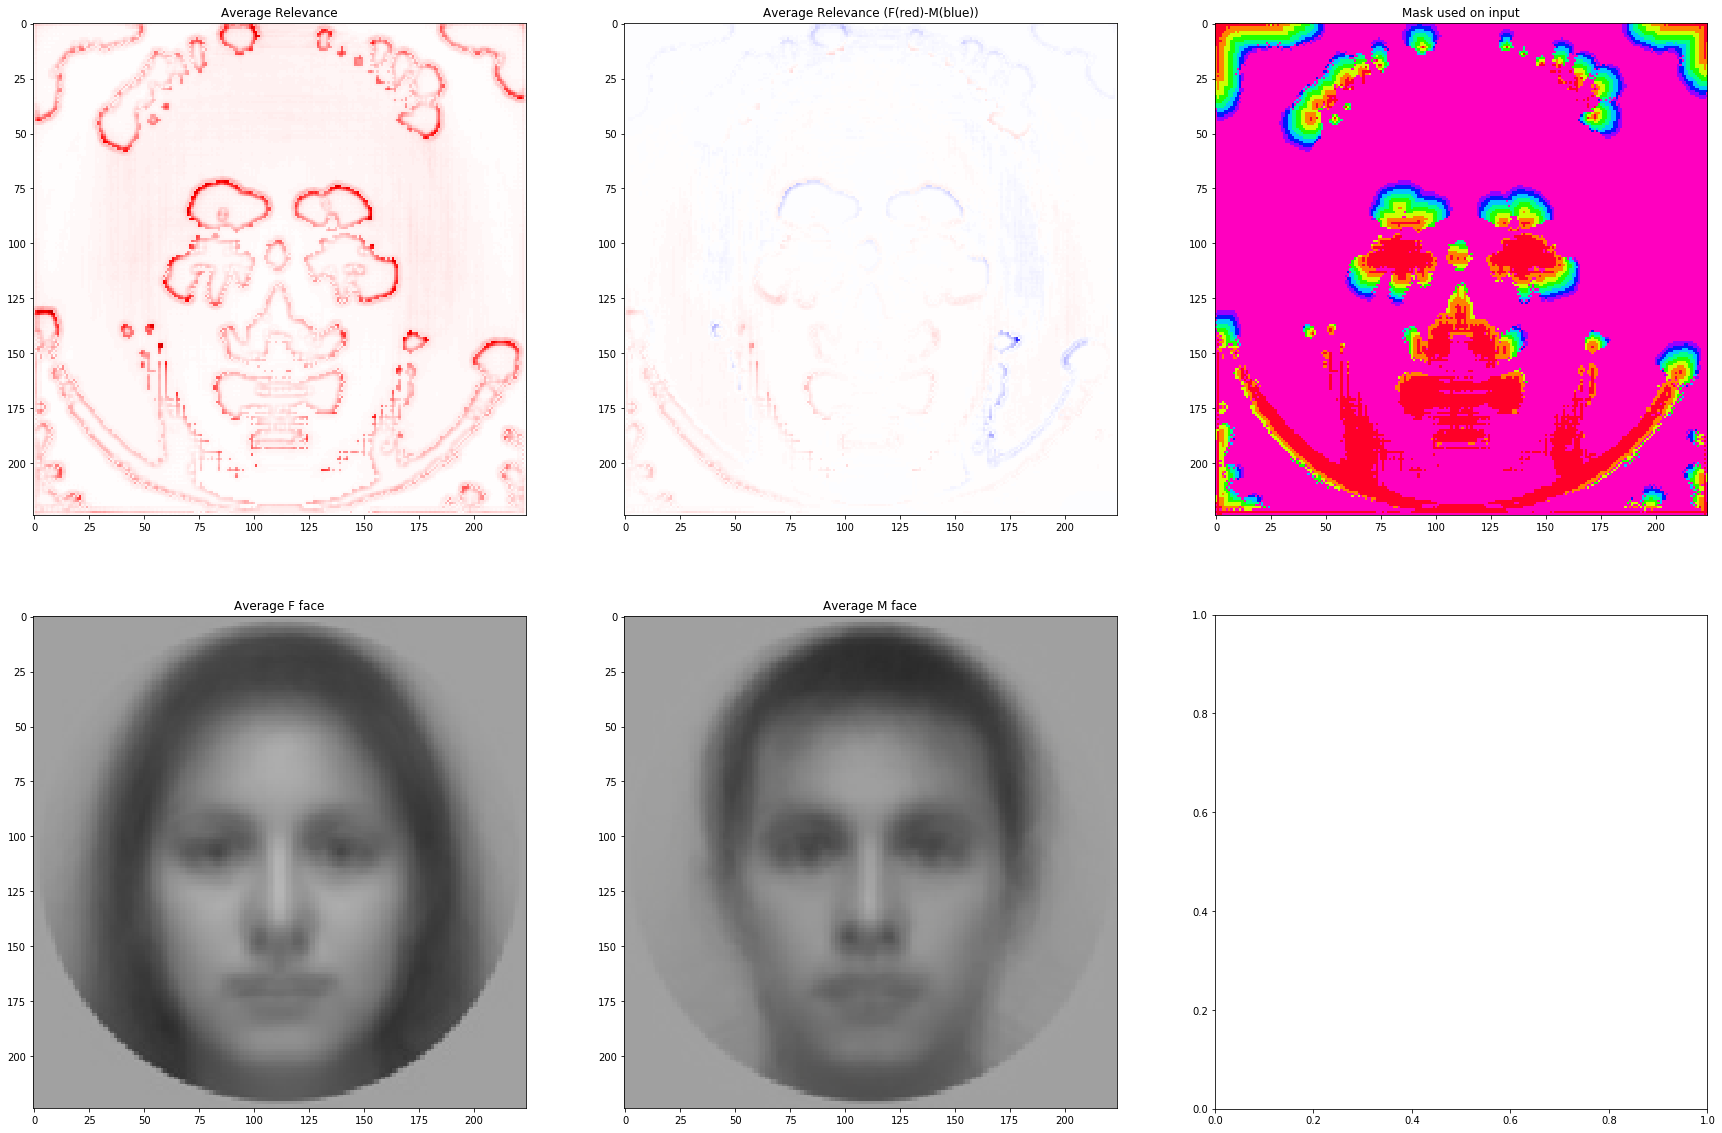

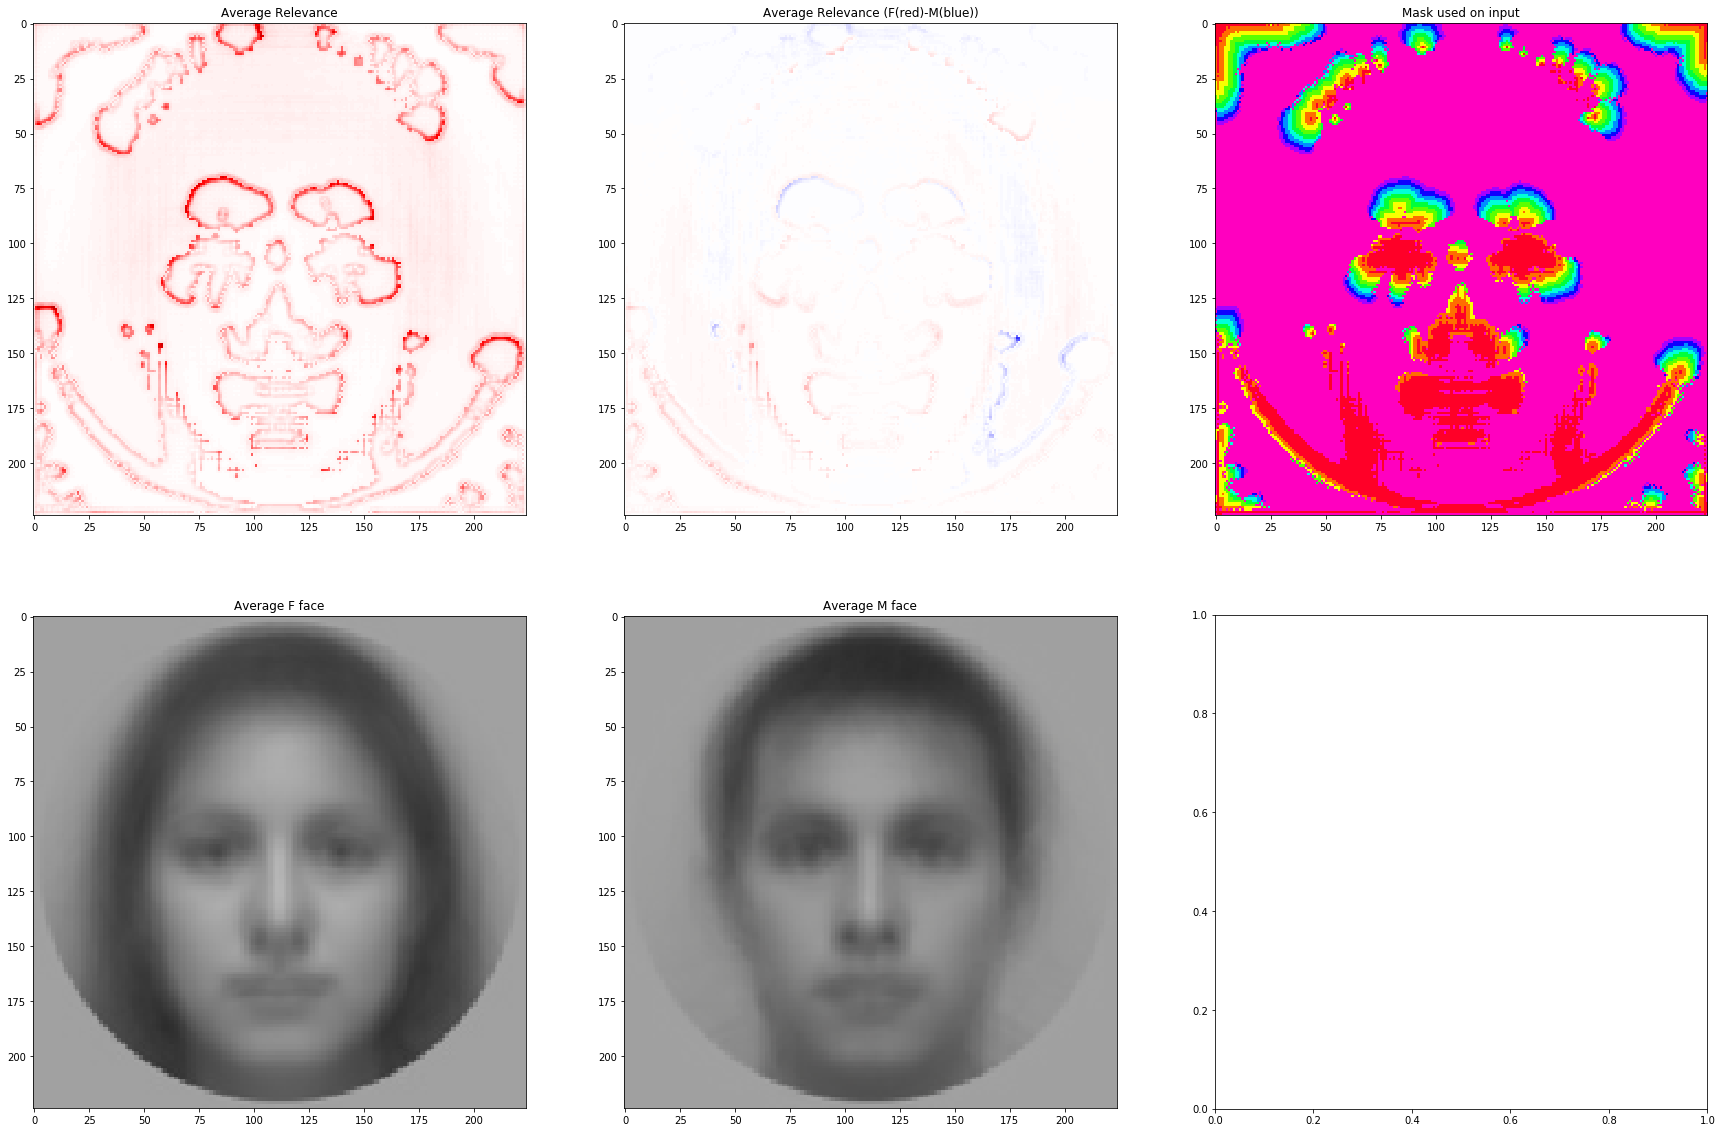

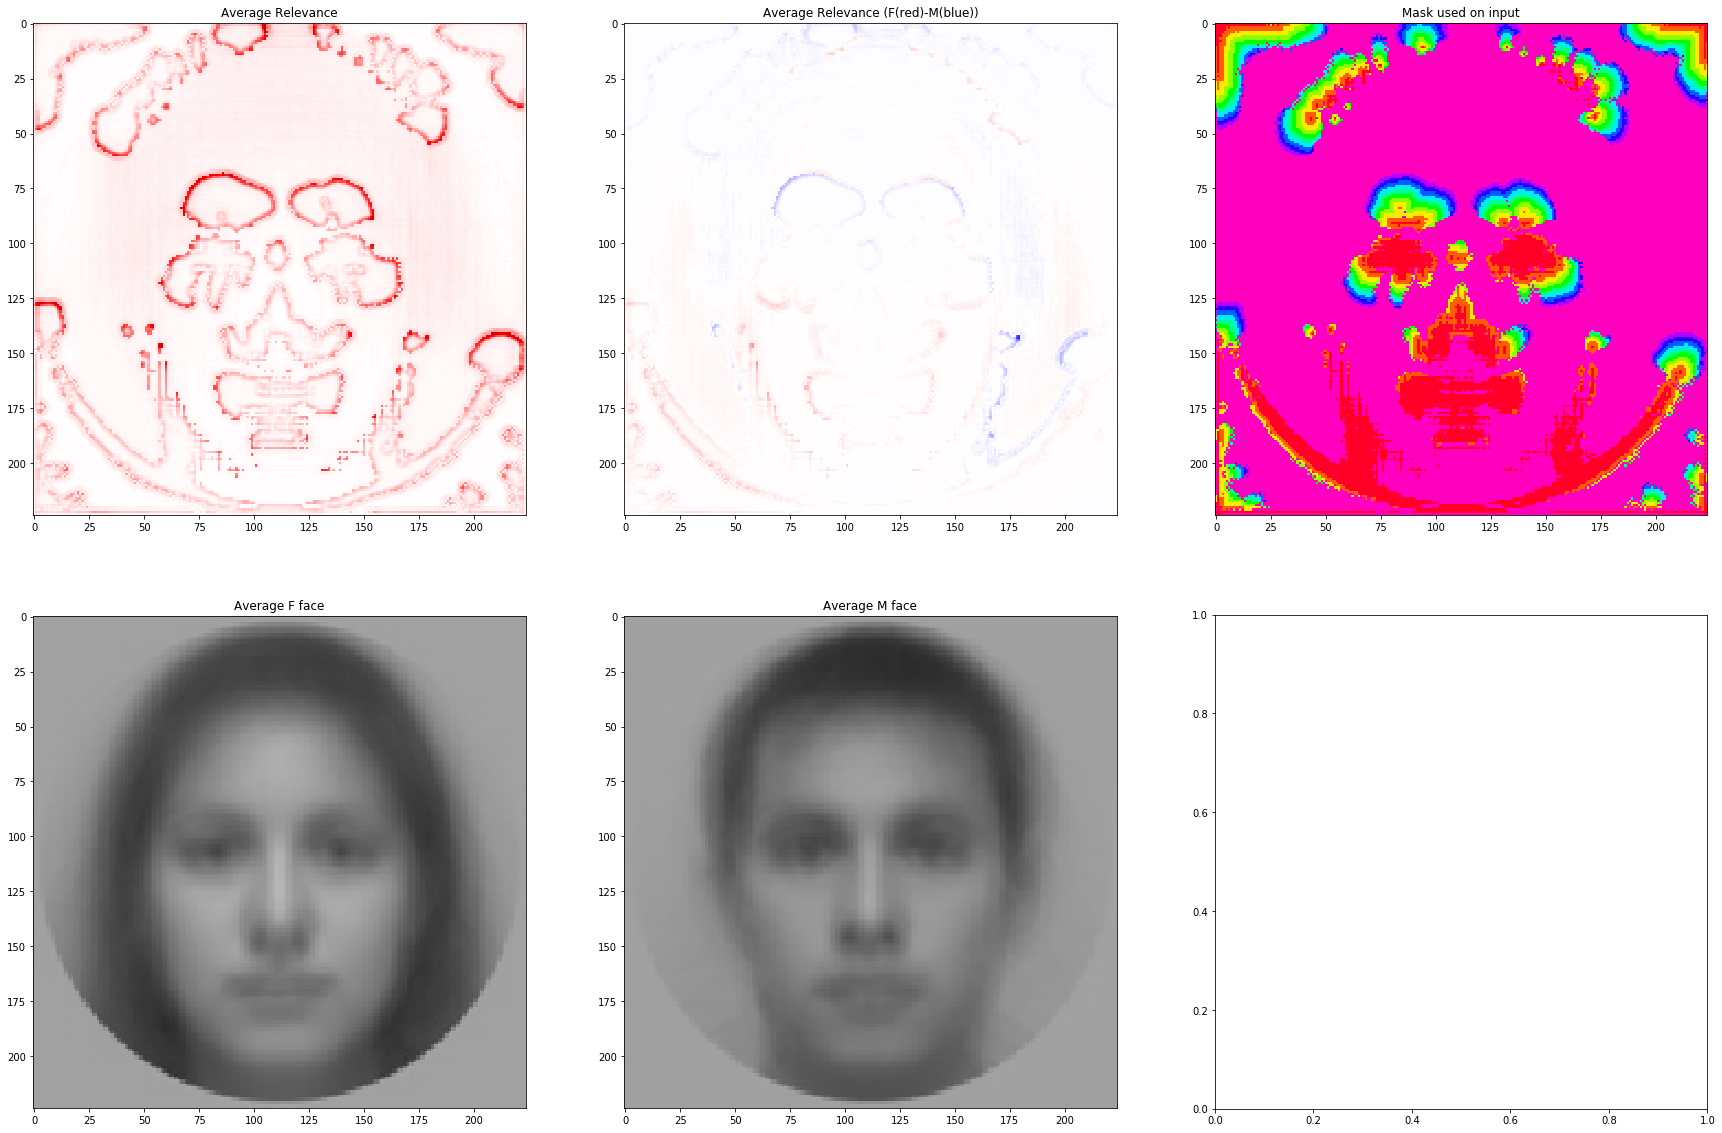

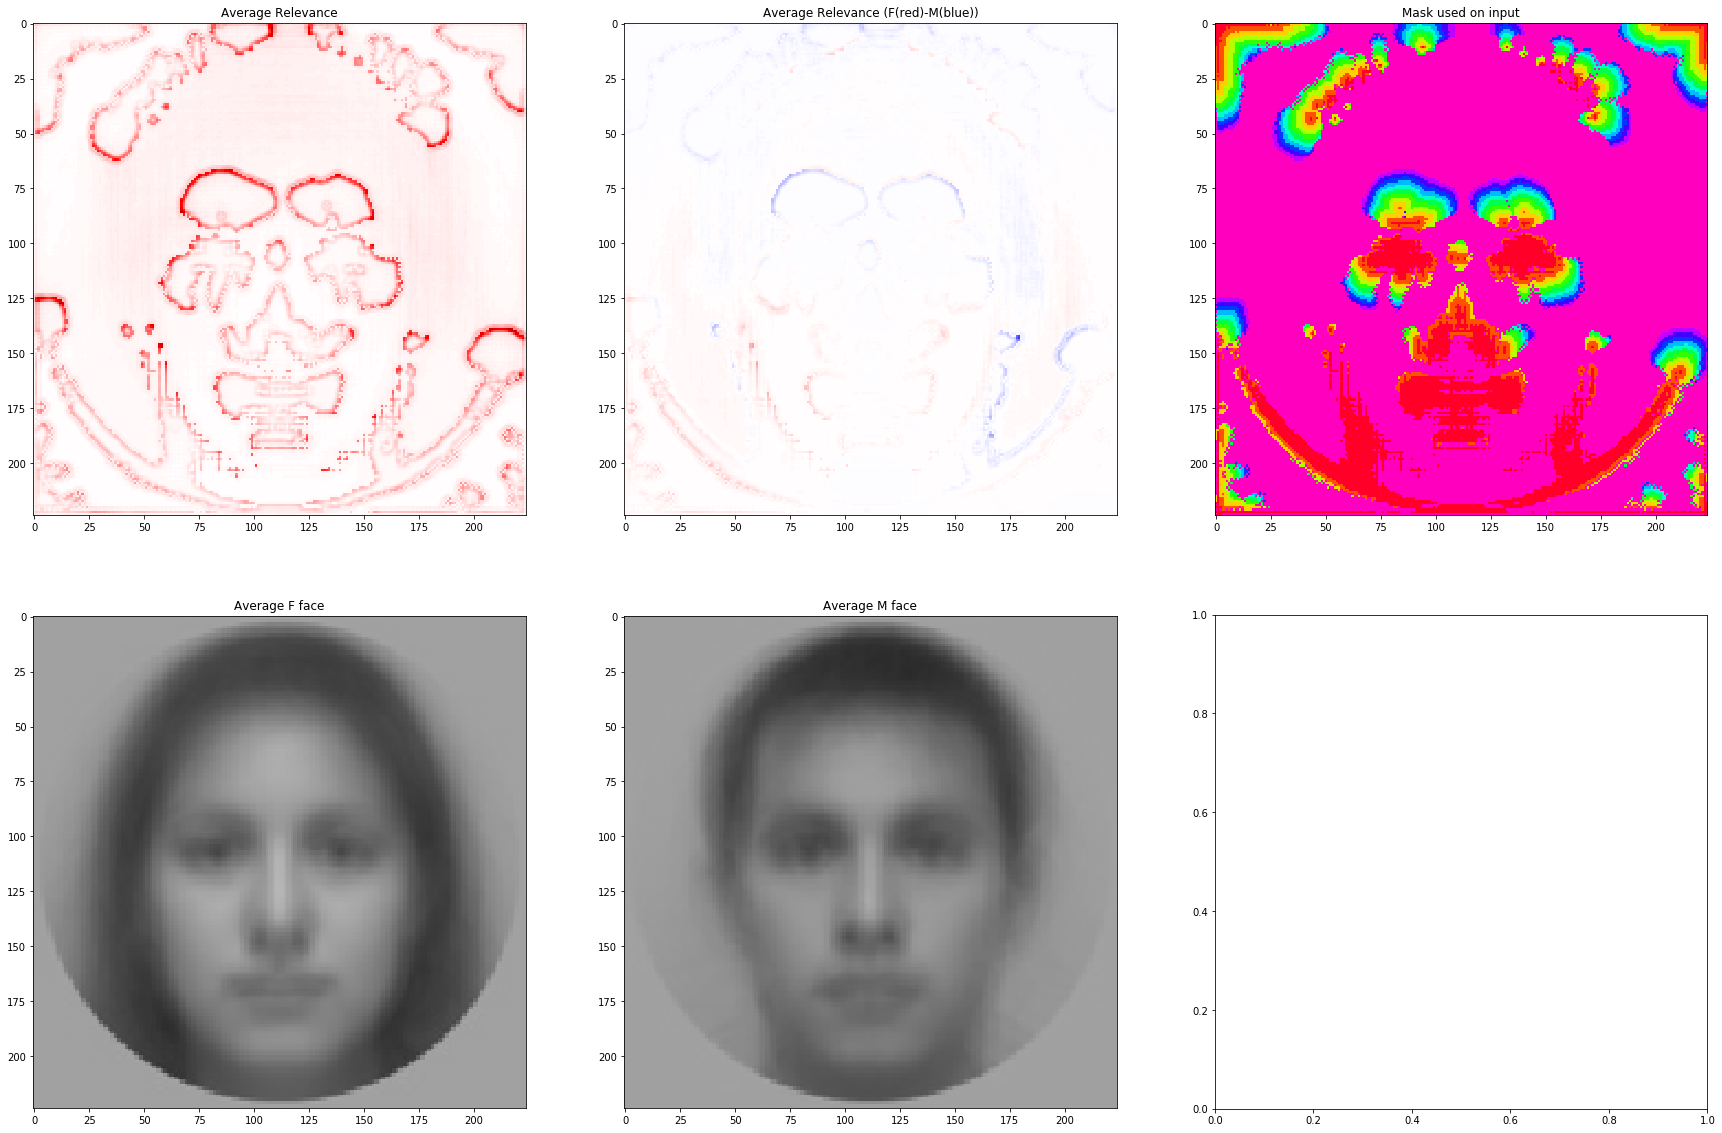

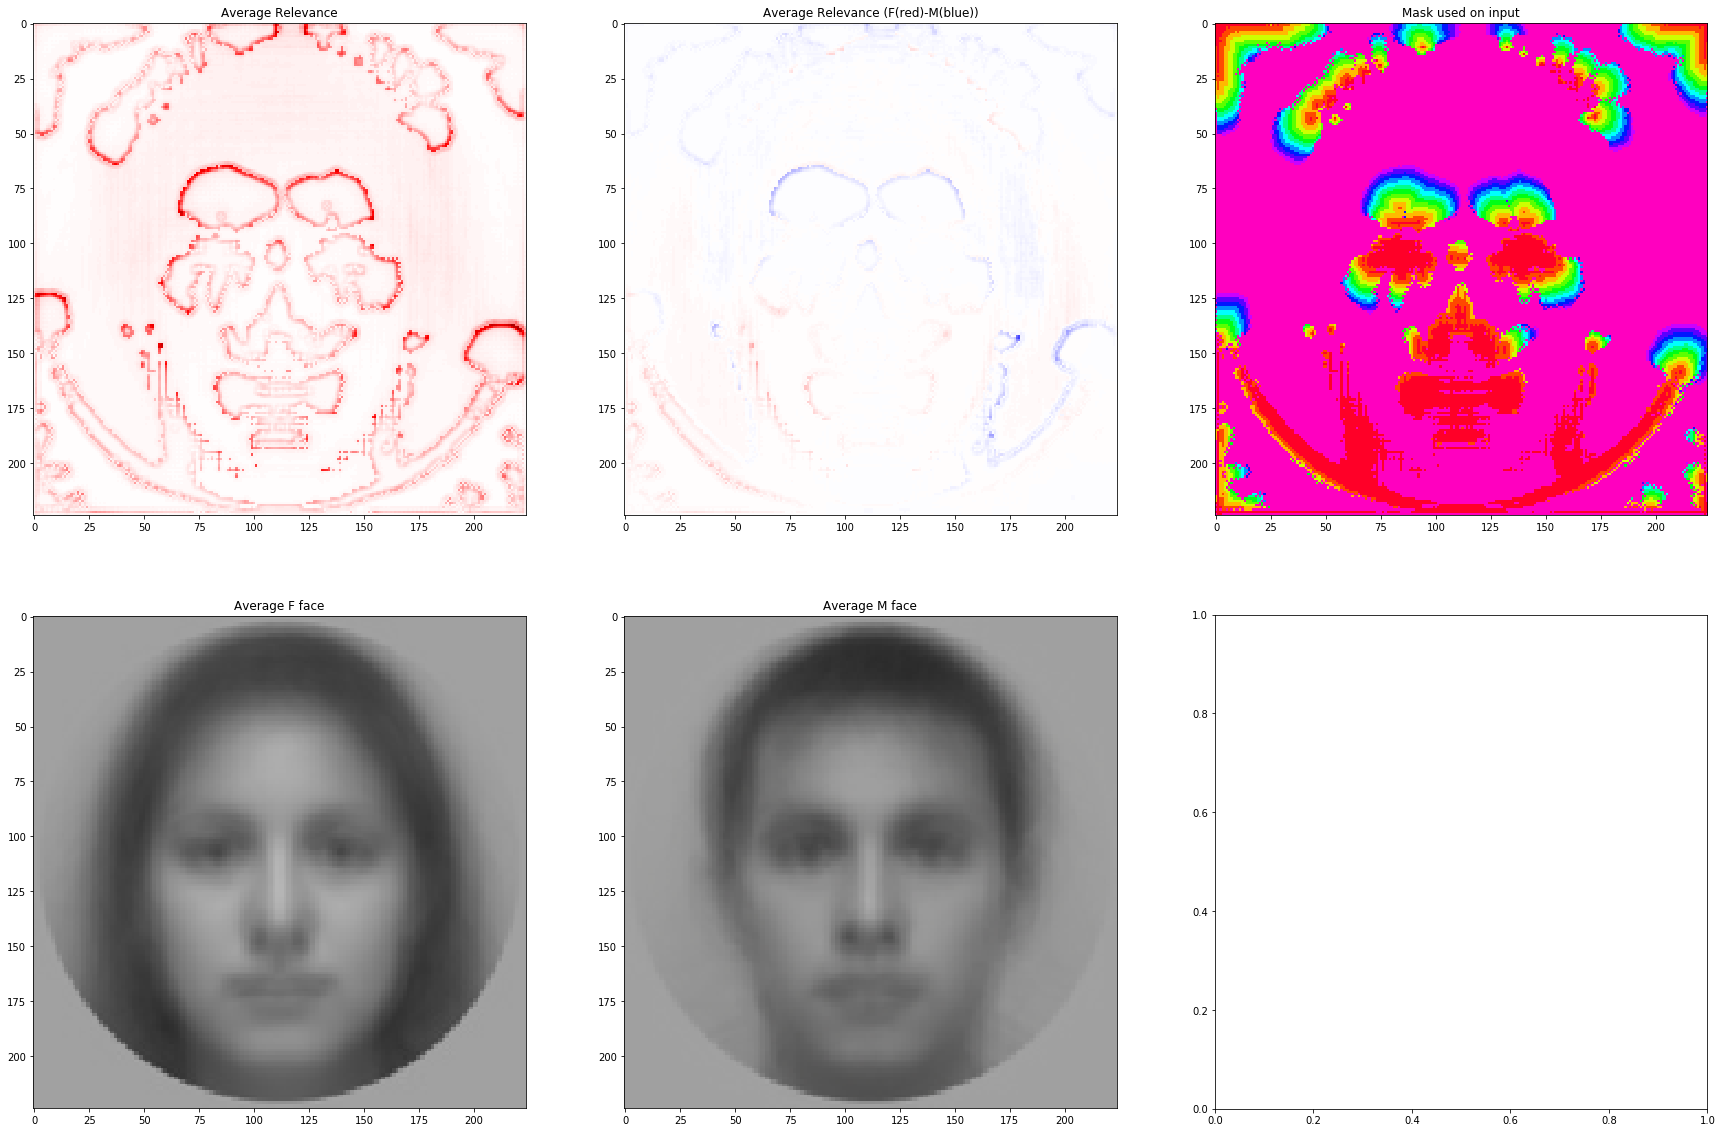

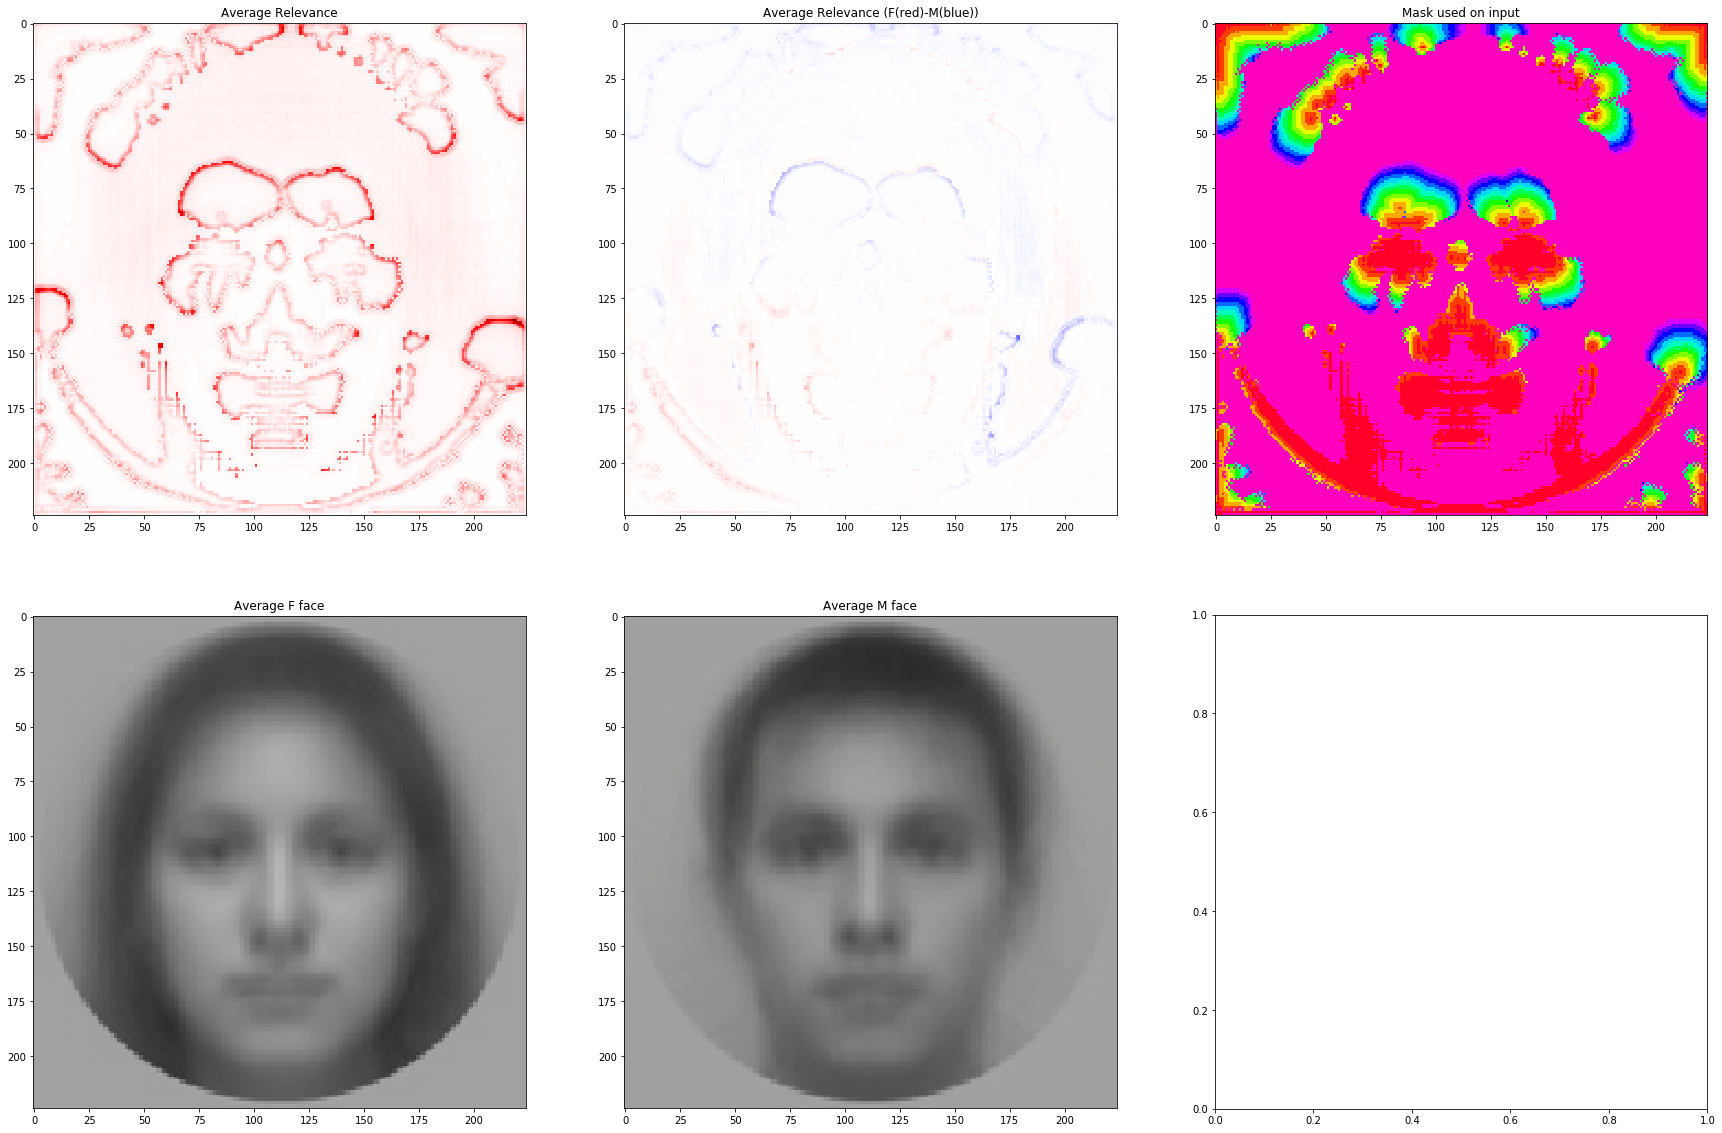

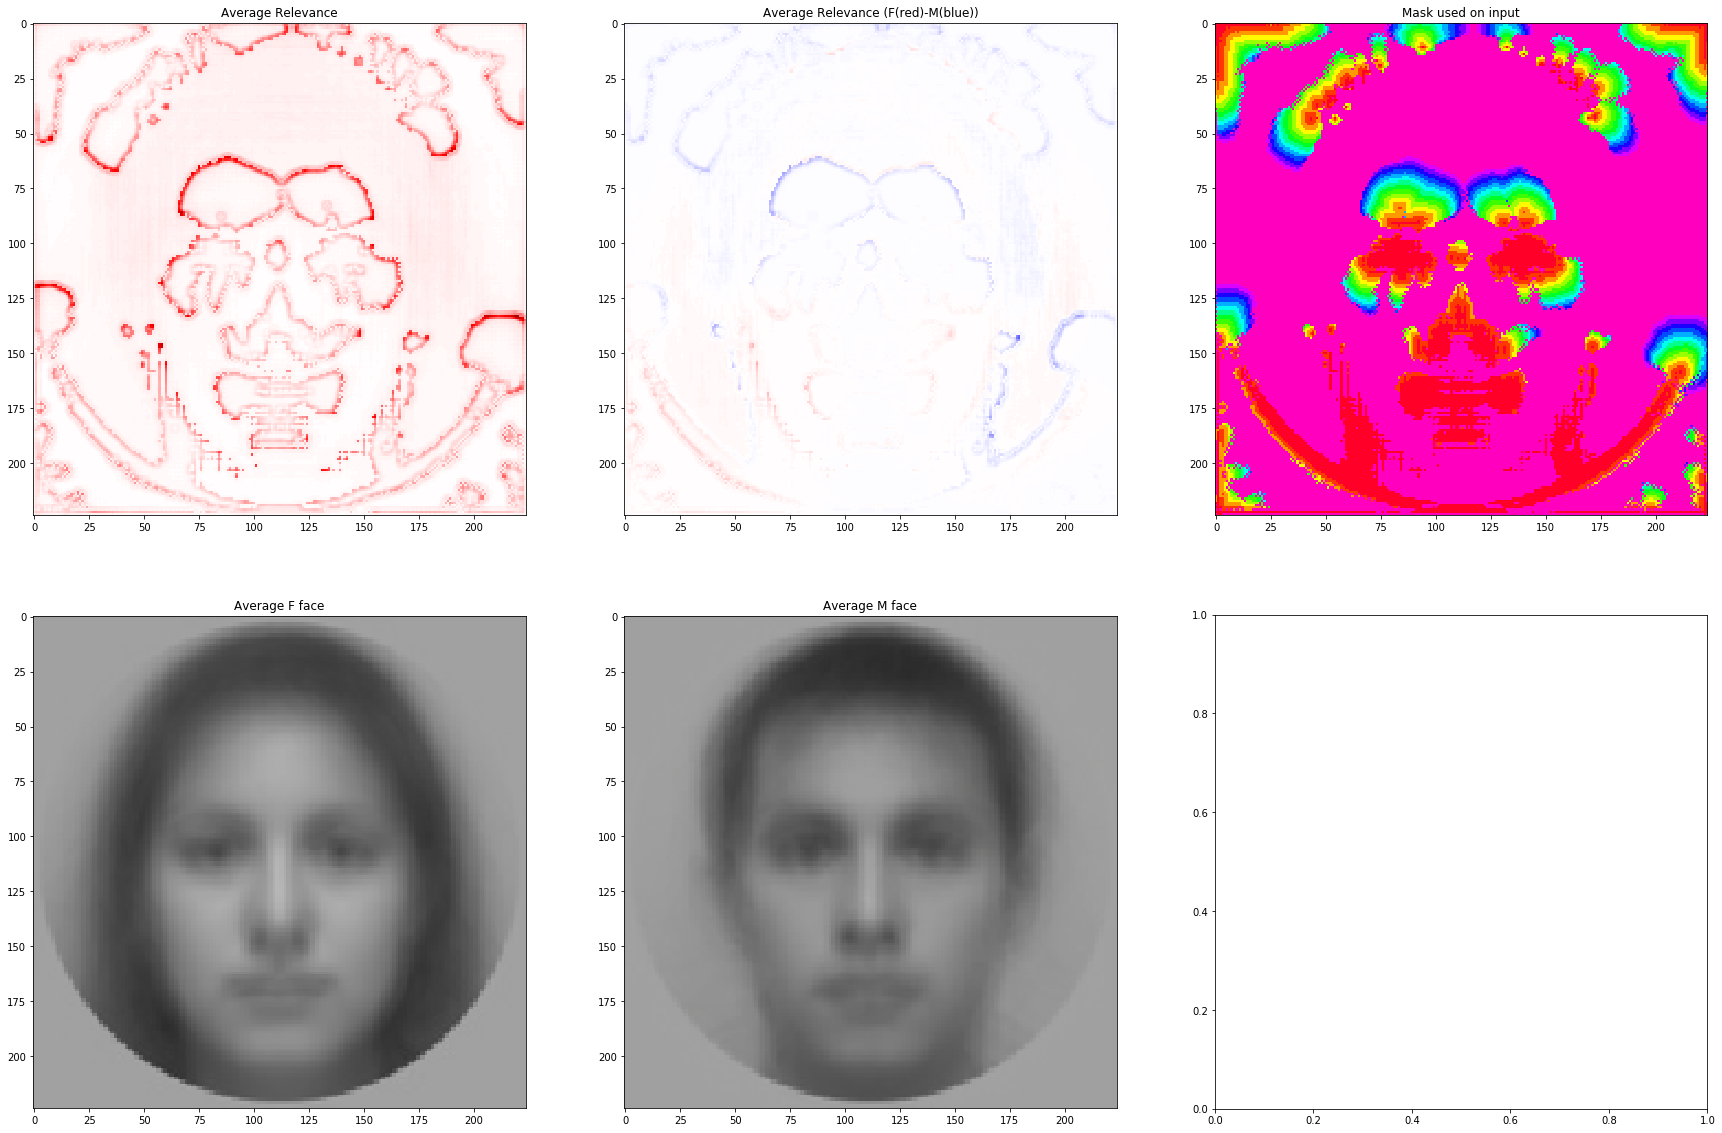

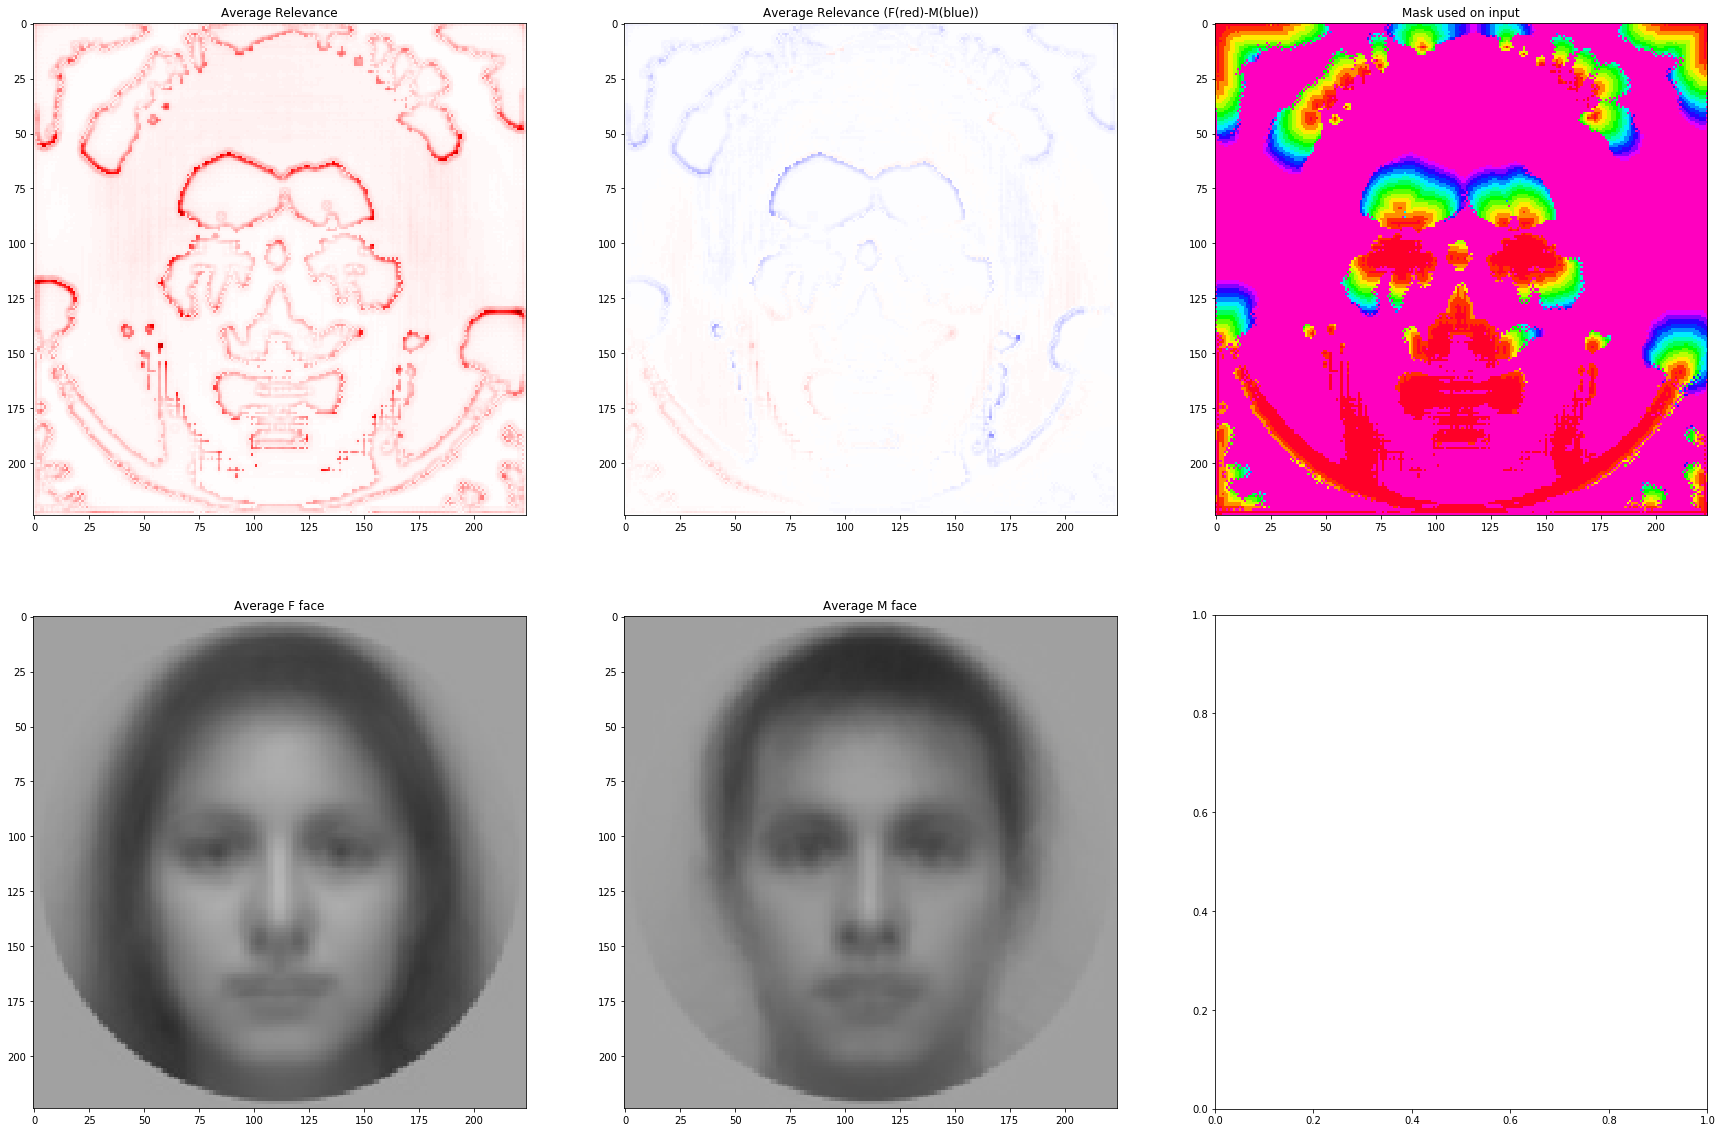

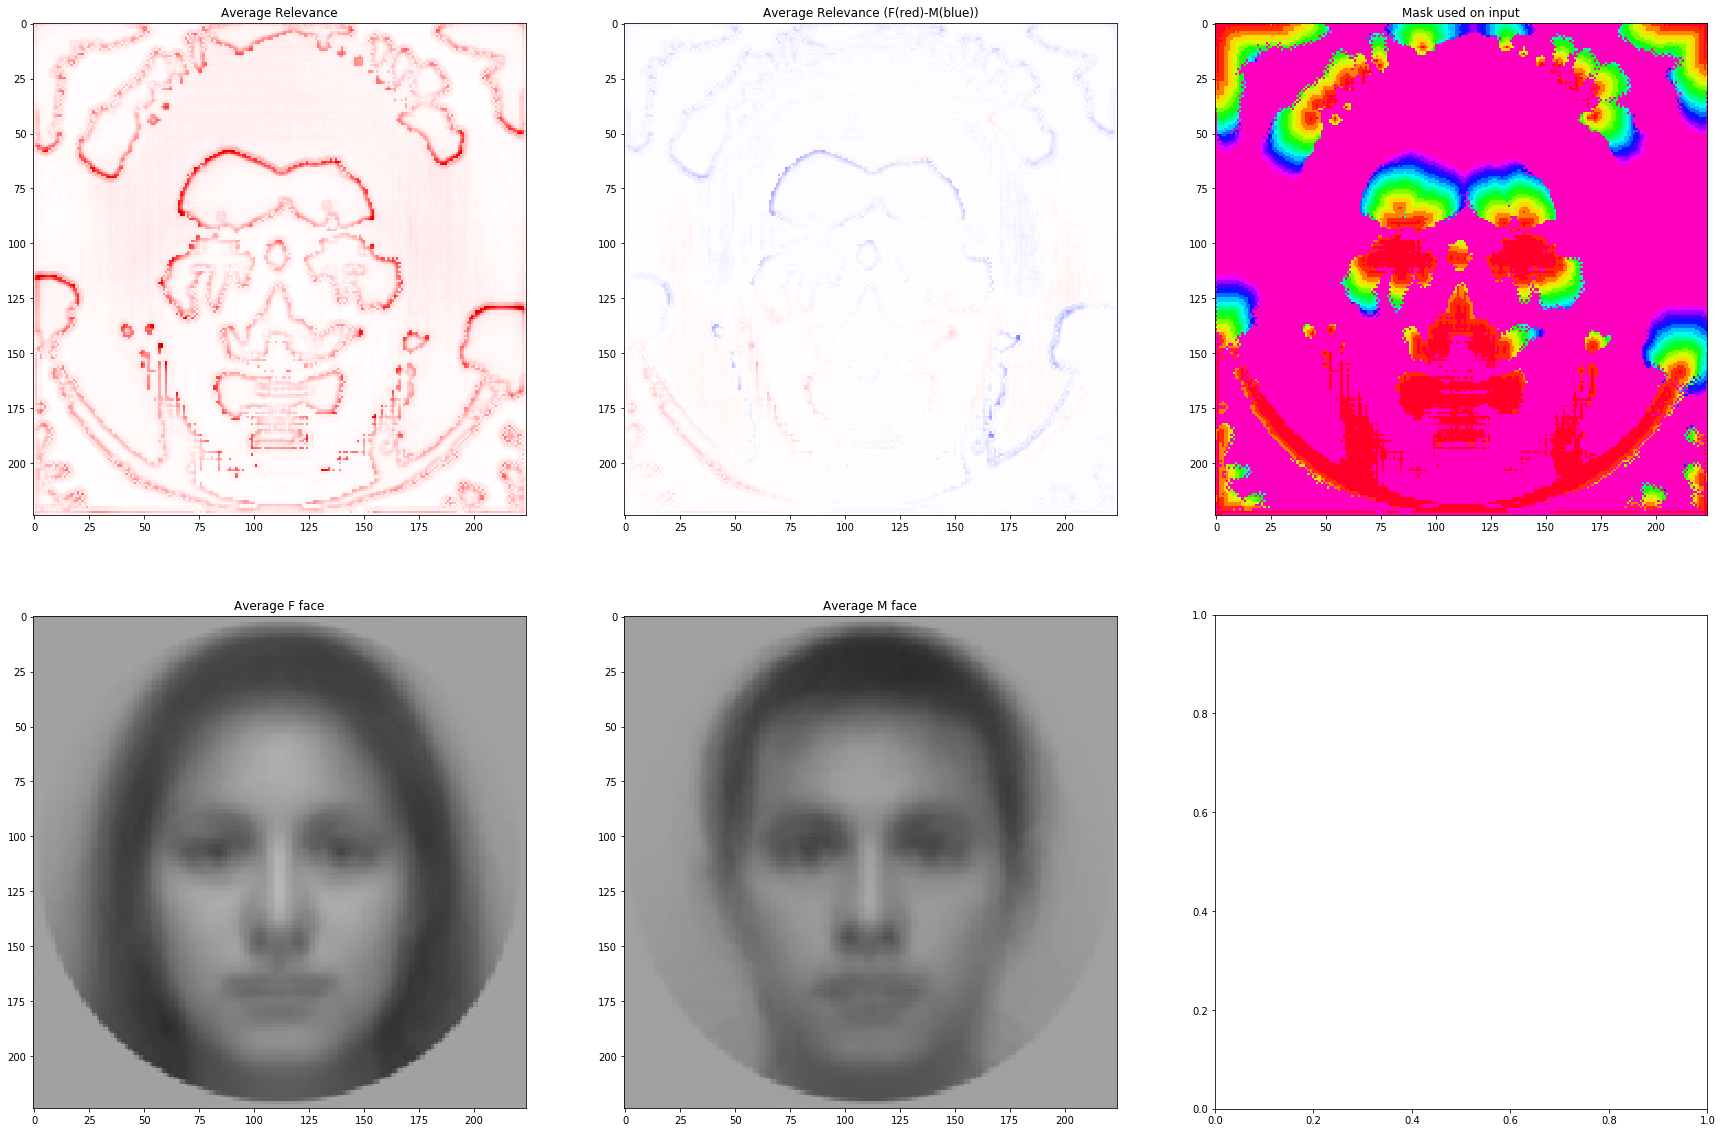

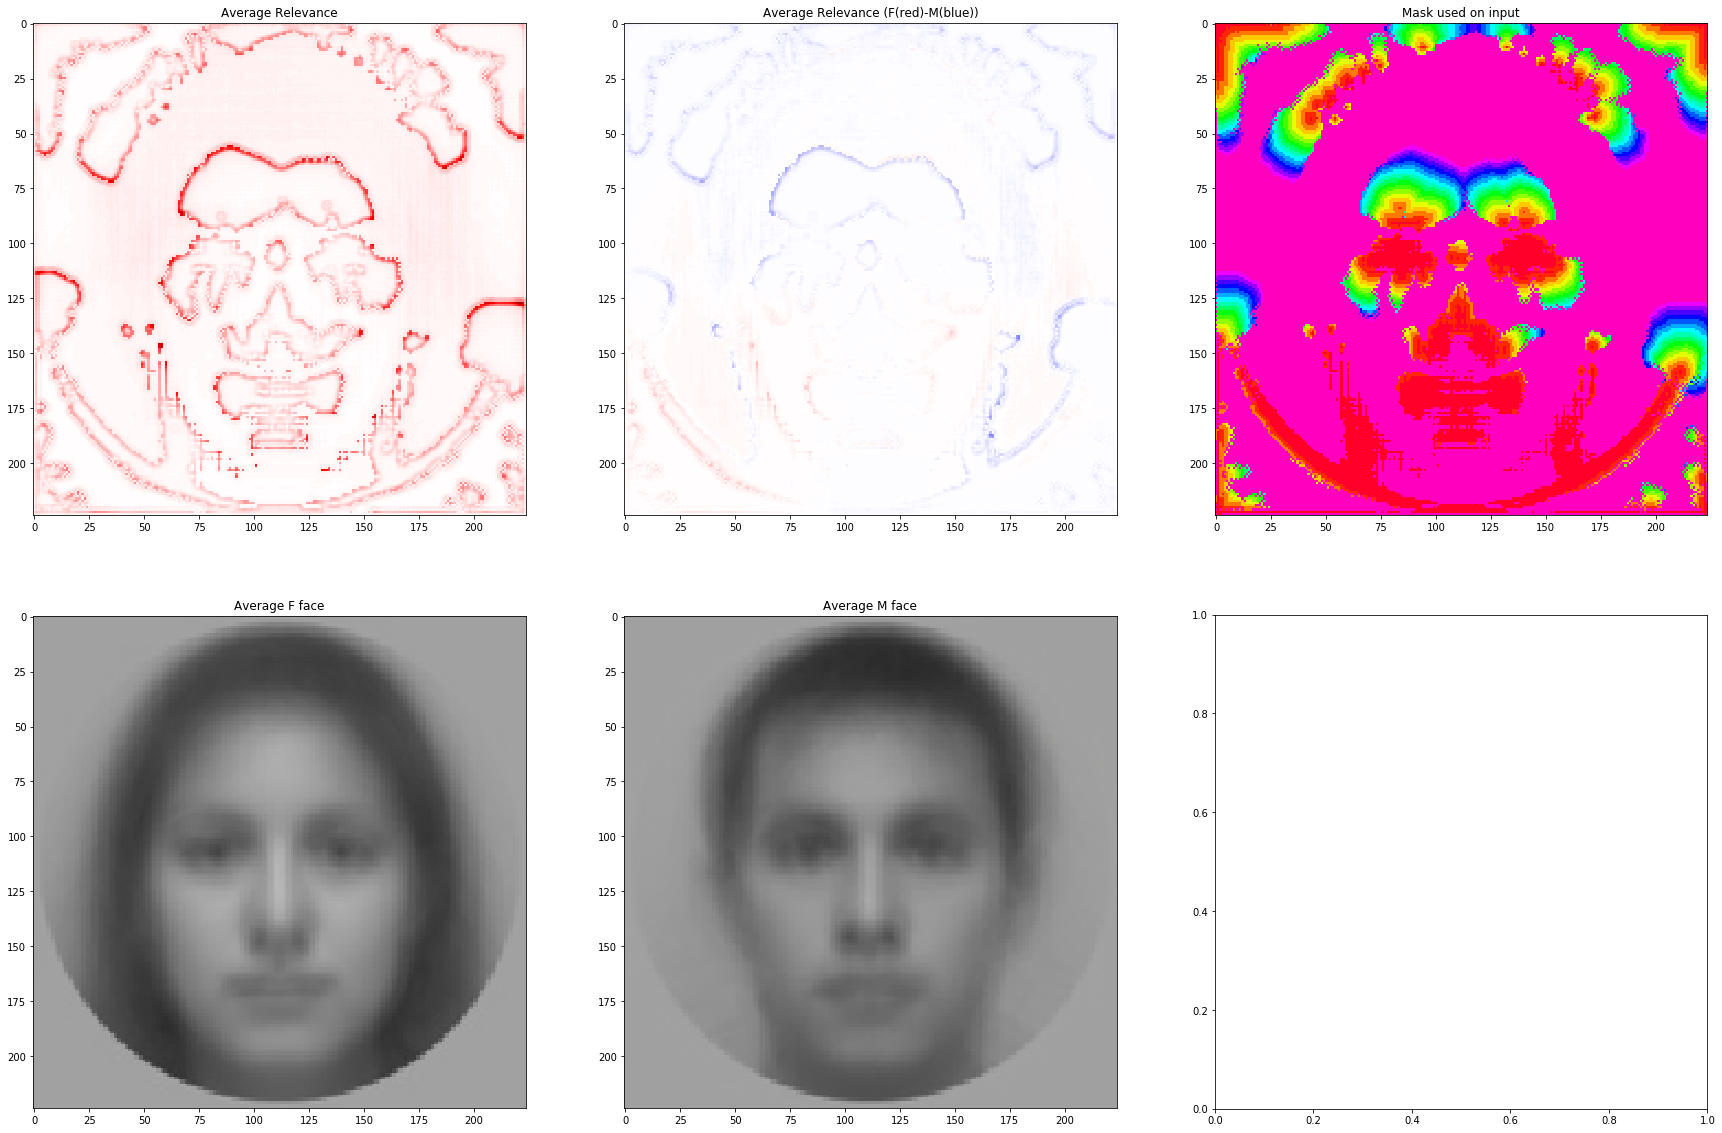

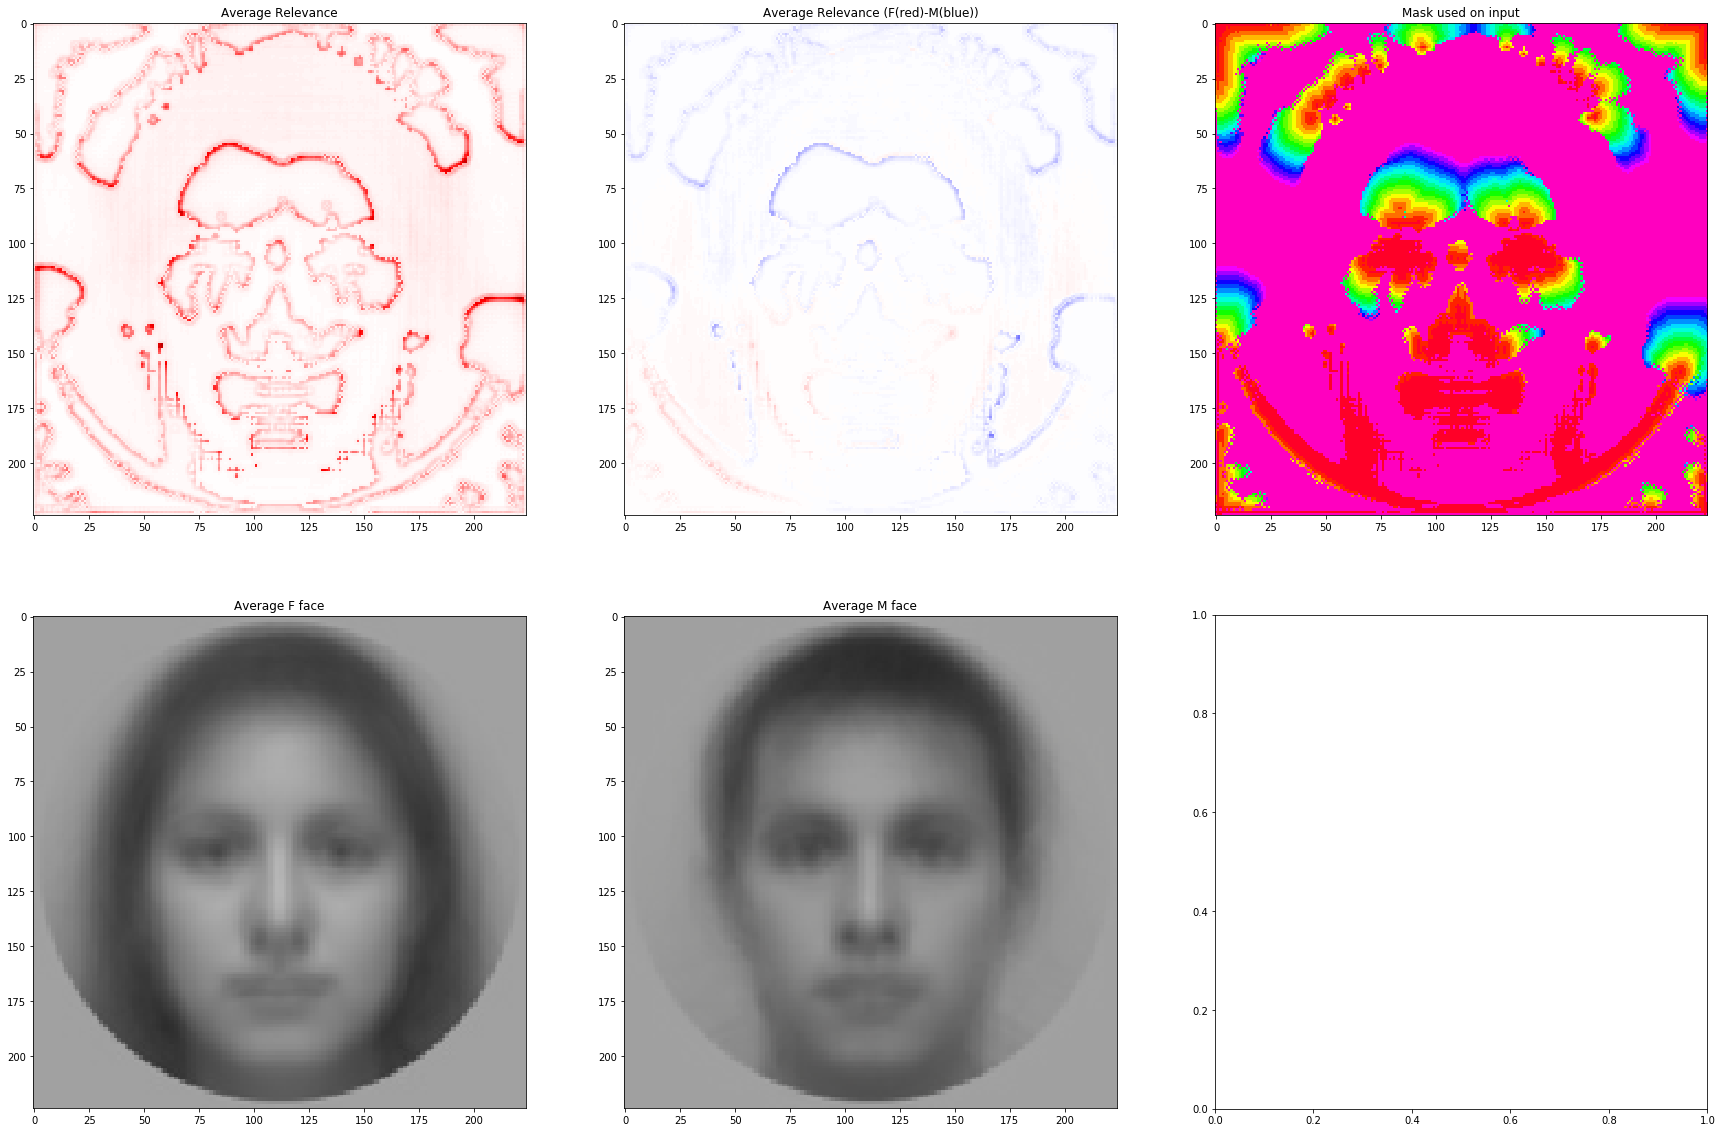

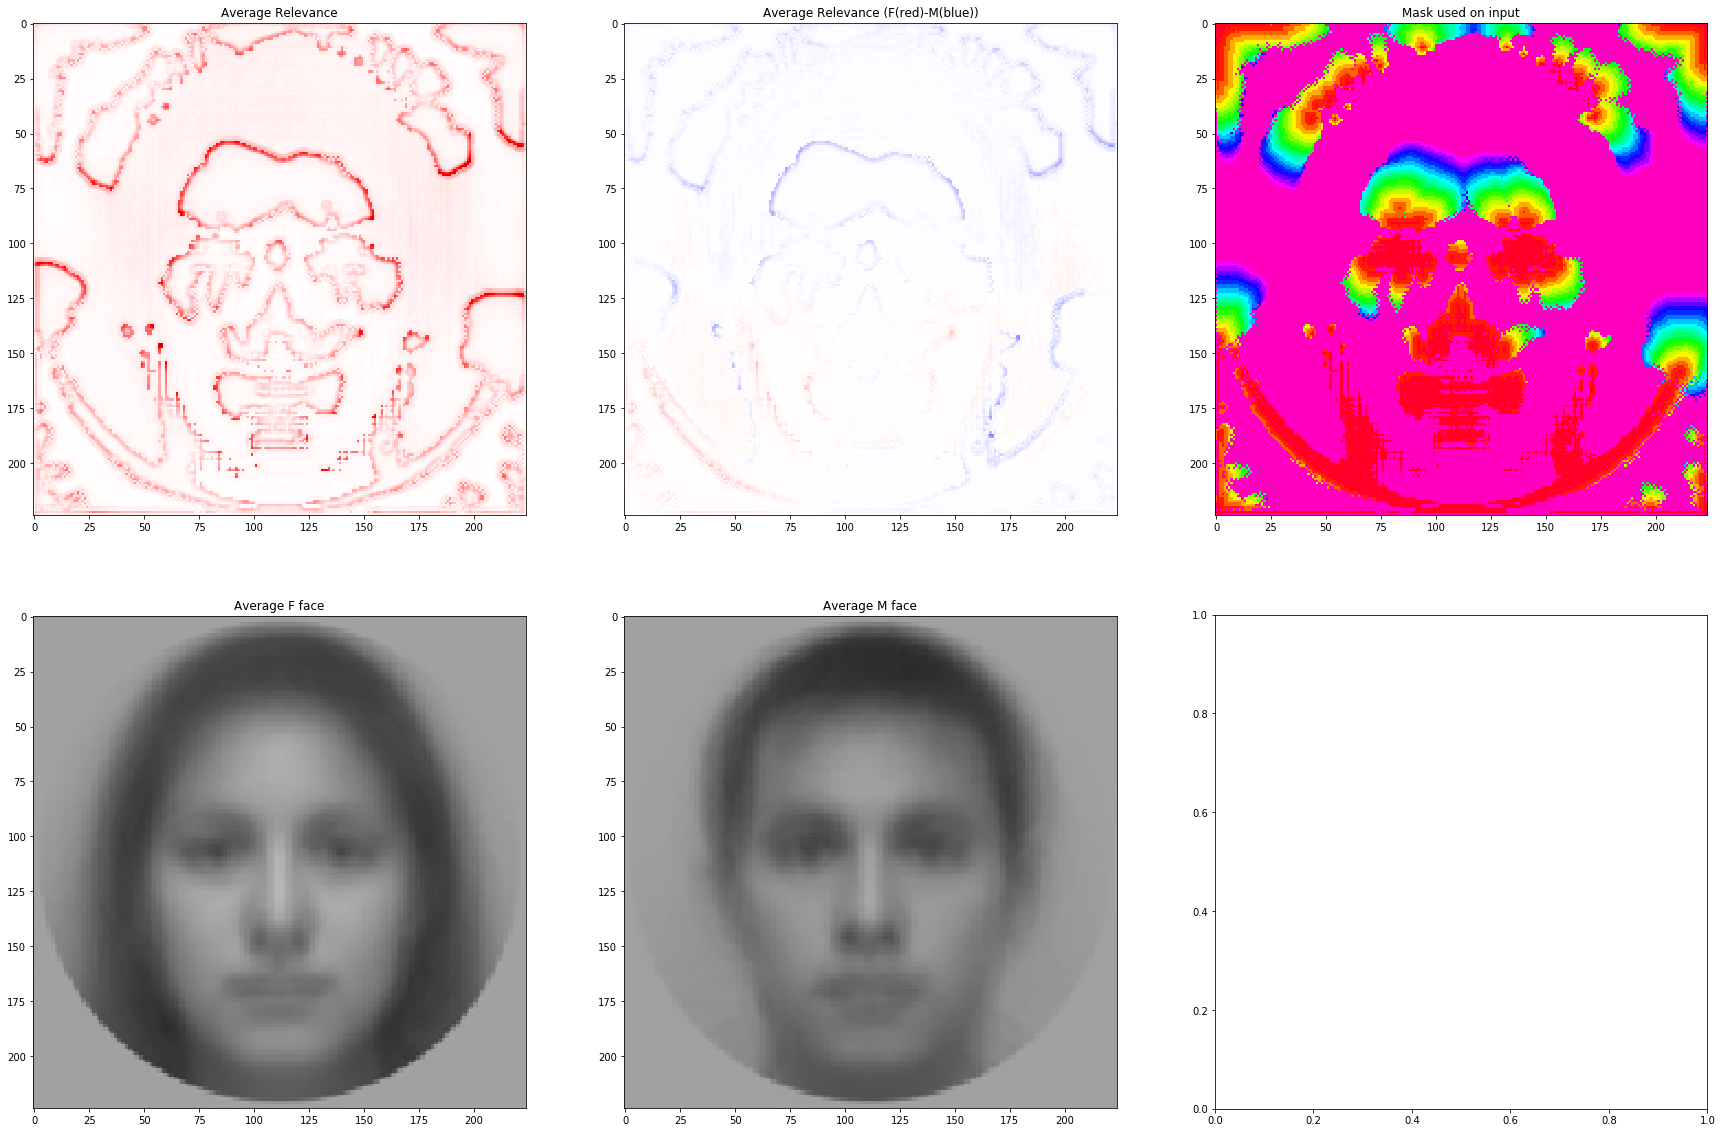

In [64]:
#thanks to Eli @ https://eli.thegreenplace.net/2016/drawing-animated-gifs-with-matplotlib/
import imageio
    
f = []
for i in range(20):
    #plot this frame's relevance, avg image used, and the mask
    fig, ax = plt.subplots(figsize=(30,20), nrows=2, ncols=3)
    
    #separate genders
    m_rs = []
    f_rs = []
    m_ps = []
    f_ps = []
    for k in range(len(front_view_filenames[:numimages])): #test on small piece first
        if (( front_view_filenames[k].split('/')[6].split('_')[1]) == 'f') :
            f_rs.append(lframes[i][0][k])
            f_ps.append(lframes[i][1][k])
        else:
            m_rs.append(lframes[i][0][k])
            m_ps.append(lframes[i][1][k])

    
    ax[0,0].imshow(np.average(lframes[i][0], axis=0), cmap="seismic", clim=[-1,1])
    ax[0,0].set_title('Average Relevance')
    
    ax[0,1].imshow(np.average(f_rs, axis=0)-np.average(m_rs, axis=0), cmap="seismic", clim=[-1,1])
    ax[0,1].set_title('Average Relevance (F(red)-M(blue))')
    
    if (i>0):
        lframes[i][2] += lframes[i-1][2]
    ax[0,2].imshow(lframes[i][2][:,:,0], cmap="gist_rainbow")
    ax[0,2].set_title('Mask used on input')
    
    ax[1,0].imshow(np.average(np.array(list(map(image_utils.img_to_array,f_ps)))/255, axis=0))
    ax[1,0].set_title('Average F face')
    
    ax[1,1].imshow(np.average(np.array(list(map(image_utils.img_to_array,m_ps)))/255, axis=0))
    ax[1,1].set_title('Average M face')

    # IMPORTANT ANIMATION CODE HERE
    # Used to keep the limits constant
    #ax.set_ylim(0, y_max)

    # Used to return the plot as an image rray
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    f.append(image)

kwargs_write = {'fps':1.0, 'quantizer':'nq'}
imageio.mimsave('./iterative_relevances_lrp.gif', f, fps=1)

## Gif
![SegmentLocal](iterative_relevances.gif "segment")